# About Dataset

## Context
This dataset contains information on user preference data from **73,516 users** on **12,294 anime**. Each user is able to add anime to their completed list and give it a rating, and this dataset is a compilation of those ratings.

## Content

### Anime.csv
- **anime_id** - myanimelist.net's unique id identifying an anime
- **name** - full name of anime
- **genre** - comma separated list of genres for this anime
- **type** - movie, TV, OVA, etc.
- **episodes** - how many episodes in this show (1 if movie)
- **rating** - average rating out of 10 for this anime
- **members** - number of community members that are in this anime's "group"

### Rating.csv
- **user_id** - non identifiable randomly generated user id
- **anime_id** - the anime that this user has rated
- **rating** - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating)

## Acknowledgements
Thanks to myanimelist.net API for providing anime data and user ratings.

## Inspiration
Building a better anime recommendation system based only on user viewing history.


## 1. Import Libraries


In [306]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import html
from collections import Counter

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


## 2. Load Data


In [307]:
anime = pd.read_csv('anime.csv')
anime_rating = pd.read_csv('rating.csv')

print("Data loaded successfully!")
print(f"Anime dataset shape: {anime.shape}")
print(f"Rating dataset shape: {anime_rating.shape}")


Data loaded successfully!
Anime dataset shape: (12294, 7)
Rating dataset shape: (7813737, 3)


## 3. Initial Data Exploration


In [308]:
# Display first few rows
print("=== Anime Dataset ===")
display(anime.head())
print("\n=== Rating Dataset ===")
display(anime_rating.head())


=== Anime Dataset ===


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266



=== Rating Dataset ===


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [309]:
# Basic statistics
print('Jumlah judul anime: ', len(anime.anime_id.unique()))
print('Jumlah genre anime: ', len(anime.genre.unique()))
print('Jumlah user: ', len(anime_rating.user_id.unique()))
print('Jumlah rating: ', len(anime_rating))


Jumlah judul anime:  12294
Jumlah genre anime:  3265
Jumlah user:  73515
Jumlah rating:  7813737


In [310]:
# Dataset info
print("=== Anime Dataset Info ===")
anime.info()
print("\n=== Rating Dataset Info ===")
anime_rating.info()


=== Anime Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB

=== Rating Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


## 4. Data Quality Validation


In [311]:
def validate_data(df, df_name):
    """Validasi kualitas data"""
    print(f"\n=== Validasi {df_name} ===")
    print(f"Shape: {df.shape}")
    print(f"Duplicates: {df.duplicated().sum()}")
    print(f"\nMissing values:")
    missing = df.isna().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing Percentage': missing_pct
    })
    print(missing_df[missing_df['Missing Count'] > 0])
    
    # Validasi range rating (harus 0-10)
    if 'rating' in df.columns:
        invalid_ratings = df[(df['rating'] < 0) | (df['rating'] > 10)]
        if len(invalid_ratings) > 0:
            print(f"\nInvalid ratings (not 0-10): {len(invalid_ratings)}")
            print(f"Rating range: {df['rating'].min()} - {df['rating'].max()}")
    
    return missing_df

# Validasi kedua dataset
missing_anime = validate_data(anime, "Anime Dataset")
missing_rating = validate_data(anime_rating, "Rating Dataset")



=== Validasi Anime Dataset ===
Shape: (12294, 7)
Duplicates: 0

Missing values:
        Missing Count  Missing Percentage
genre              62            0.504311
type               25            0.203351
rating            230            1.870831

=== Validasi Rating Dataset ===
Shape: (7813737, 3)
Duplicates: 1

Missing values:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []

Invalid ratings (not 0-10): 1476496
Rating range: -1 - 10


## 5. Data Preprocessing

### 5.1 Handling Missing Values


In [312]:
# Analisis missing values lebih detail
print("=== Missing Values Analysis ===")
print("\nAnime Dataset:")
print(anime.isna().sum())
print(f"\nTotal rows before: {len(anime)}")

# Strategi: Drop rows dengan missing values pada kolom penting
# Genre dan Type bisa diisi dengan "Unknown", tapi untuk konsistensi kita drop
anime = anime.dropna()
print(f"Total rows after dropna: {len(anime)}")


=== Missing Values Analysis ===

Anime Dataset:
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Total rows before: 12294
Total rows after dropna: 12017


In [313]:
# Check missing values in rating dataset
print("Rating Dataset missing values:")
print(anime_rating.isna().sum())


Rating Dataset missing values:
user_id     0
anime_id    0
rating      0
dtype: int64


### 5.2 Handling Duplicates


In [314]:
# Check duplicates in anime dataset
dup_anime = anime[anime.duplicated()].shape[0]
print(f"Terdapat {dup_anime} duplikat dari {anime.shape[0]} sample pada anime dataset.")

# Check duplicates in rating dataset
dup_rating = anime_rating[anime_rating.duplicated()].shape[0]
print(f"Terdapat {dup_rating} duplikat dari {anime_rating.shape[0]} sample pada rating anime dataset.")

# Remove duplicates from rating dataset
if dup_rating > 0:
    anime_rating.drop_duplicates(keep='first', inplace=True)
    print(f"Sample rating anime dataset sekarang adalah {anime_rating.shape[0]}.")


Terdapat 0 duplikat dari 12017 sample pada anime dataset.
Terdapat 1 duplikat dari 7813737 sample pada rating anime dataset.
Sample rating anime dataset sekarang adalah 7813736.


### 5.3 Data Type Conversion


In [315]:
# Convert episodes to numeric (handle 'Unknown' or invalid values)
print("Episodes data type before:", anime['episodes'].dtype)
print("Sample episodes values:", anime['episodes'].head(10).tolist())

# Convert to numeric, invalid values become NaN
anime['episodes'] = pd.to_numeric(anime['episodes'], errors='coerce')

# Check how many became NaN
episodes_nan = anime['episodes'].isna().sum()
print(f"\nEpisodes converted to numeric. NaN count: {episodes_nan}")

# Fill NaN episodes with median or 1 (for movies)
if episodes_nan > 0:
    median_episodes = anime['episodes'].median()
    anime['episodes'] = anime['episodes'].fillna(median_episodes)
    print(f"Filled {episodes_nan} NaN episodes with median: {median_episodes}")

print("\nEpisodes data type after:", anime['episodes'].dtype)
print("Episodes statistics:")
print(anime['episodes'].describe())


Episodes data type before: object
Sample episodes values: ['1', '64', '51', '24', '51', '10', '148', '110', '1', '13']

Episodes converted to numeric. NaN count: 187
Filled 187 NaN episodes with median: 2.0

Episodes data type after: float64
Episodes statistics:
count    12017.000000
mean        12.323542
std         46.747242
min          1.000000
25%          1.000000
50%          2.000000
75%         12.000000
max       1818.000000
Name: episodes, dtype: float64


### 5.4 Text Cleaning


In [316]:
def text_cleaning(text):
    """Fungsi untuk membersihkan text dari karakter tidak diinginkan"""
    if not isinstance(text, str):
        return text
    
    # Decode HTML entities
    text = html.unescape(text)
    
    # Hapus semua tanda kutip dan apostrof
    text = re.sub(r'["\']', '', text)
    text = re.sub(r'\.hack//', '', text)
    text = re.sub(r'&', 'and', text)
    
    return text

# Perbaikan: gunakan .copy() untuk menghindari SettingWithCopyWarning
anime = anime.copy()
anime['name'] = anime['name'].apply(text_cleaning)

print("Text cleaning completed!")
print("Sample cleaned names:")
print(anime['name'].head(10))


Text cleaning completed!
Sample cleaned names:
0                                       Kimi no Na wa.
1                     Fullmetal Alchemist: Brotherhood
2                                             Gintama°
3                                          Steins;Gate
4                                              Gintama
5    Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...
6                               Hunter x Hunter (2011)
7                                 Ginga Eiyuu Densetsu
8    Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...
9                                   Gintama: Enchousen
Name: name, dtype: object


### 5.5 Outlier Detection


In [317]:
def detect_outliers_iqr(df, column):
    """Deteksi outlier menggunakan IQR method"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Deteksi outlier pada rating
outliers_rating, lower_r, upper_r = detect_outliers_iqr(anime, 'rating')
print(f"Outliers in rating: {len(outliers_rating)}")
print(f"Rating bounds: [{lower_r:.2f}, {upper_r:.2f}]")

# Deteksi outlier pada members
outliers_members, lower_m, upper_m = detect_outliers_iqr(anime, 'members')
print(f"\nOutliers in members: {len(outliers_members)}")
print(f"Members bounds: [{lower_m:.2f}, {upper_m:.2f}]")

# Note: Kita tidak akan menghapus outlier karena mungkin valid (anime populer memang punya members banyak)
print("\nNote: Outliers tidak dihapus karena mungkin valid data")


Outliers in rating: 235
Rating bounds: [3.95, 9.12]

Outliers in members: 1869
Members bounds: [-13819.50, 23632.50]

Note: Outliers tidak dihapus karena mungkin valid data


### 5.6 Data Filtering


In [318]:
# Filter rating -1 (user watched but didn't rate)
print(f"Rating dataset before filtering: {len(anime_rating)}")
print(f"Ratings with -1: {len(anime_rating[anime_rating.rating == -1])}")

anime_rating = anime_rating[~(anime_rating.rating == -1)]
print(f"Rating dataset after filtering: {len(anime_rating)}")

# Validasi rating range
invalid_ratings = anime_rating[(anime_rating['rating'] < 0) | (anime_rating['rating'] > 10)]
if len(invalid_ratings) > 0:
    print(f"\nWarning: Found {len(invalid_ratings)} invalid ratings (not 0-10)")
else:
    print("\nAll ratings are in valid range (0-10)")


Rating dataset before filtering: 7813736
Ratings with -1: 1476496
Rating dataset after filtering: 6337240

All ratings are in valid range (0-10)


### 5.7 Feature Engineering


In [319]:
# Jumlah genre per anime
anime['genre_list'] = anime['genre'].apply(
    lambda x: [g.strip() for g in str(x).split(',')] if pd.notna(x) else []
)
anime['genre_count'] = anime['genre_list'].apply(len)

print("Genre count statistics:")
print(anime['genre_count'].describe())


Genre count statistics:
count    12017.000000
mean         2.962054
std          1.665691
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         13.000000
Name: genre_count, dtype: float64


In [320]:
# Analisis genre paling populer
all_genres = [genre for sublist in anime['genre_list'] for genre in sublist]
genre_counts = Counter(all_genres)
print("Top 15 Most Popular Genres:")
for genre, count in genre_counts.most_common(15):
    print(f"  {genre}: {count}")


Top 15 Most Popular Genres:
  Comedy: 4575
  Action: 2768
  Adventure: 2316
  Fantasy: 2242
  Sci-Fi: 2036
  Drama: 1977
  Shounen: 1684
  Kids: 1598
  Romance: 1437
  Slice of Life: 1204
  School: 1176
  Hentai: 1133
  Supernatural: 1001
  Mecha: 929
  Music: 842


In [321]:
# Normalisasi members (opsional, untuk skala yang berbeda)
scaler = MinMaxScaler()
anime['members_normalized'] = scaler.fit_transform(anime[['members']])

# Kategorisasi rating
anime['rating_category'] = pd.cut(
    anime['rating'], 
    bins=[0, 5, 7, 8, 10], 
    labels=['Low', 'Medium', 'High', 'Very High']
)

print("Feature engineering completed!")
print("\nNew features added:")
print("- genre_list: List of genres")
print("- genre_count: Number of genres")
print("- members_normalized: Normalized members count")
print("- rating_category: Categorized rating")


Feature engineering completed!

New features added:
- genre_list: List of genres
- genre_count: Number of genres
- members_normalized: Normalized members count
- rating_category: Categorized rating


In [322]:
# Encoding categorical variable 'type' (opsional untuk model ML)
le = LabelEncoder()
anime['type_encoded'] = le.fit_transform(anime['type'].fillna('Unknown'))

print("Type encoding completed!")
print(f"Unique types: {anime['type'].unique()}")
print(f"Encoded values: {dict(zip(le.classes_, range(len(le.classes_))))}")


Type encoding completed!
Unique types: ['Movie' 'TV' 'OVA' 'Special' 'Music' 'ONA']
Encoded values: {'Movie': 0, 'Music': 1, 'ONA': 2, 'OVA': 3, 'Special': 4, 'TV': 5}


### 5.8 Collaborative Filtering Preprocessing


In [323]:
# Analisis sparsity matrix
def calculate_sparsity(df):
    """Hitung sparsity dari rating matrix"""
    n_users = df['user_id'].nunique()
    n_anime = df['anime_id'].nunique()
    n_ratings = len(df)
    sparsity = 1 - (n_ratings / (n_users * n_anime))
    print(f"Number of users: {n_users:,}")
    print(f"Number of anime: {n_anime:,}")
    print(f"Number of ratings: {n_ratings:,}")
    print(f"Sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")
    return sparsity

sparsity = calculate_sparsity(anime_rating)


Number of users: 69,600
Number of anime: 9,927
Number of ratings: 6,337,240
Sparsity: 0.9908 (99.08%)


In [324]:
# Filter user dan anime dengan rating terlalu sedikit (cold start problem)
# Ini opsional, bisa diaktifkan jika diperlukan
min_user_ratings = 50
min_anime_ratings = 10

user_counts = anime_rating['user_id'].value_counts()
anime_counts = anime_rating['anime_id'].value_counts()

print(f"Users with < {min_user_ratings} ratings: {(user_counts < min_user_ratings).sum()}")
print(f"Anime with < {min_anime_ratings} ratings: {(anime_counts < min_anime_ratings).sum()}")

# Uncomment untuk apply filtering (akan mengurangi data significantly)
# anime_rating_filtered = anime_rating[
#     (anime_rating['user_id'].isin(user_counts[user_counts >= min_user_ratings].index)) &
#     (anime_rating['anime_id'].isin(anime_counts[anime_counts >= min_anime_ratings].index))
# ]
# print(f"\nData setelah filtering: {len(anime_rating_filtered):,} dari {len(anime_rating):,}")
# anime_rating = anime_rating_filtered  # Uncomment untuk menggunakan filtered data


Users with < 50 ratings: 36633
Anime with < 10 ratings: 2562


## 6. Data Summary After Preprocessing


In [325]:
print("=== Final Dataset Summary ===")
print(f"\nAnime Dataset:")
print(f"  Shape: {anime.shape}")
print(f"  Columns: {list(anime.columns)}")
print(f"\nRating Dataset:")
print(f"  Shape: {anime_rating.shape}")
print(f"  Columns: {list(anime_rating.columns)}")

print("\n=== Statistical Summary ===")
print("\nAnime Dataset:")
print(anime.describe().apply(lambda s: s.apply('{0:.2f}'.format)))

print("\nRating Dataset:")
print(anime_rating.describe().apply(lambda s: s.apply('{0:.2f}'.format)))


=== Final Dataset Summary ===

Anime Dataset:
  Shape: (12017, 12)
  Columns: ['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members', 'genre_list', 'genre_count', 'members_normalized', 'rating_category', 'type_encoded']

Rating Dataset:
  Shape: (6337240, 3)
  Columns: ['user_id', 'anime_id', 'rating']

=== Statistical Summary ===

Anime Dataset:
       anime_id  episodes    rating     members genre_count  \
count  12017.00  12017.00  12017.00    12017.00    12017.00   
mean   13638.00     12.32      6.48    18348.88        2.96   
std    11231.08     46.75      1.02    55372.50        1.67   
min        1.00      1.00      1.67       12.00        1.00   
25%     3391.00      1.00      5.89      225.00        2.00   
50%     9959.00      2.00      6.57     1552.00        3.00   
75%    23729.00     12.00      7.18     9588.00        4.00   
max    34519.00   1818.00     10.00  1013917.00       13.00   

      members_normalized type_encoded  
count           12017.00    

## 7. Data Visualization

### 7.1 Anime Categories Distribution


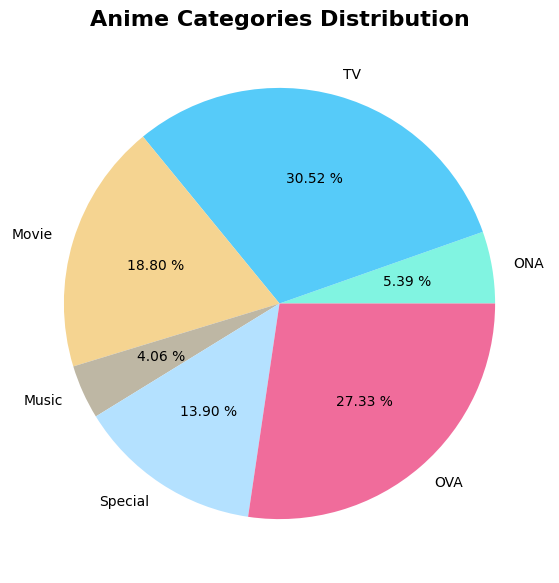

In [326]:
ona = len(anime.loc[anime['type'] == 'ONA'])
tv = len(anime.loc[anime['type'] == 'TV'])
movie = len(anime.loc[anime['type'] == 'Movie'])
music = len(anime.loc[anime['type'] == 'Music'])
special = len(anime.loc[anime['type'] == 'Special'])
ova = len(anime.loc[anime['type'] == 'OVA'])

labels = ['ONA', 'TV', 'Movie', 'Music', 'Special', 'OVA']
colors = ['#81F4E1', '#56CBF9', '#F5D491', '#BEB7A4', '#B4E1FF', '#F06C9B']

plt.figure(figsize = (10,7))
plt.title('Anime Categories Distribution', fontsize=16, fontweight='bold')
plt.pie([ona, tv, movie, music, special, ova],
  labels = labels,
  colors = colors,
  autopct = '%.2f %%'
  )
  
plt.show()


### 7.2 Anime's Average Ratings Distribution


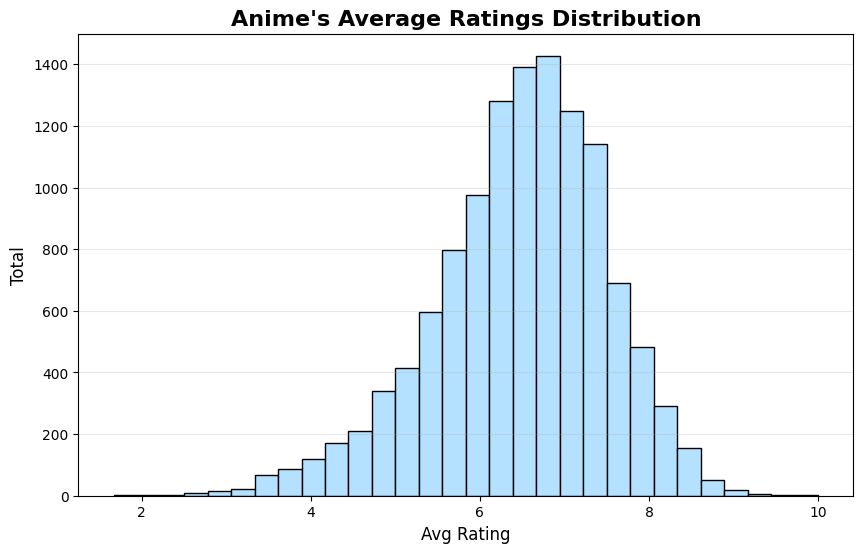

In [327]:
plt.figure(figsize=(10, 6))
plt.hist(anime.rating, color='#B4E1FF', edgecolor='black', bins=30)
plt.ylabel('Total', fontsize=12)
plt.xlabel('Avg Rating', fontsize=12)
plt.title("Anime's Average Ratings Distribution", fontsize=16, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()


### 7.3 User Anime Ratings Distribution


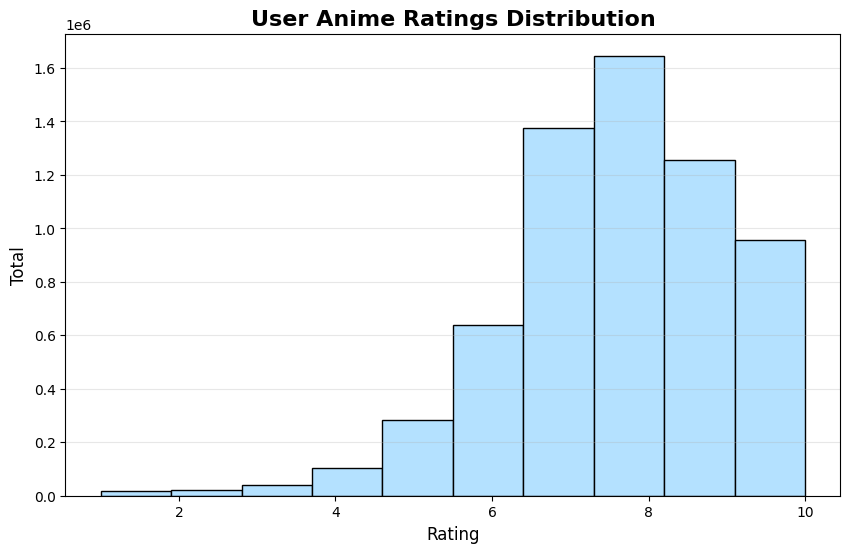

In [328]:
plt.figure(figsize=(10, 6))
plt.hist(anime_rating.rating, color='#B4E1FF', edgecolor='black', bins=10)
plt.ylabel('Total', fontsize=12)
plt.xlabel('Rating', fontsize=12)
plt.title("User Anime Ratings Distribution", fontsize=16, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()


### 7.4 Top 10 Anime by Community Members


In [329]:
top10_anime_members = anime.sort_values(by='members', ascending=False).head(10)
print("Top 10 Anime by Community Members:")
display(top10_anime_members[['name', 'members', 'rating', 'type']])


Top 10 Anime by Community Members:


,name,members,rating,type
40,Death Note,1013917,8.71,TV
86,Shingeki no Kyojin,896229,8.54,TV
804,Sword Art Online,893100,7.83,TV
1,Fullmetal Alchemist: Brotherhood,793665,9.26,TV
159,Angel Beats!,717796,8.39,TV
19,Code Geass: Hangyaku no Lelouch,715151,8.83,TV
841,Naruto,683297,7.81,TV
3,Steins;Gate,673572,9.17,TV
445,Mirai Nikki (TV),657190,8.07,TV
131,Toradora!,633817,8.45,TV


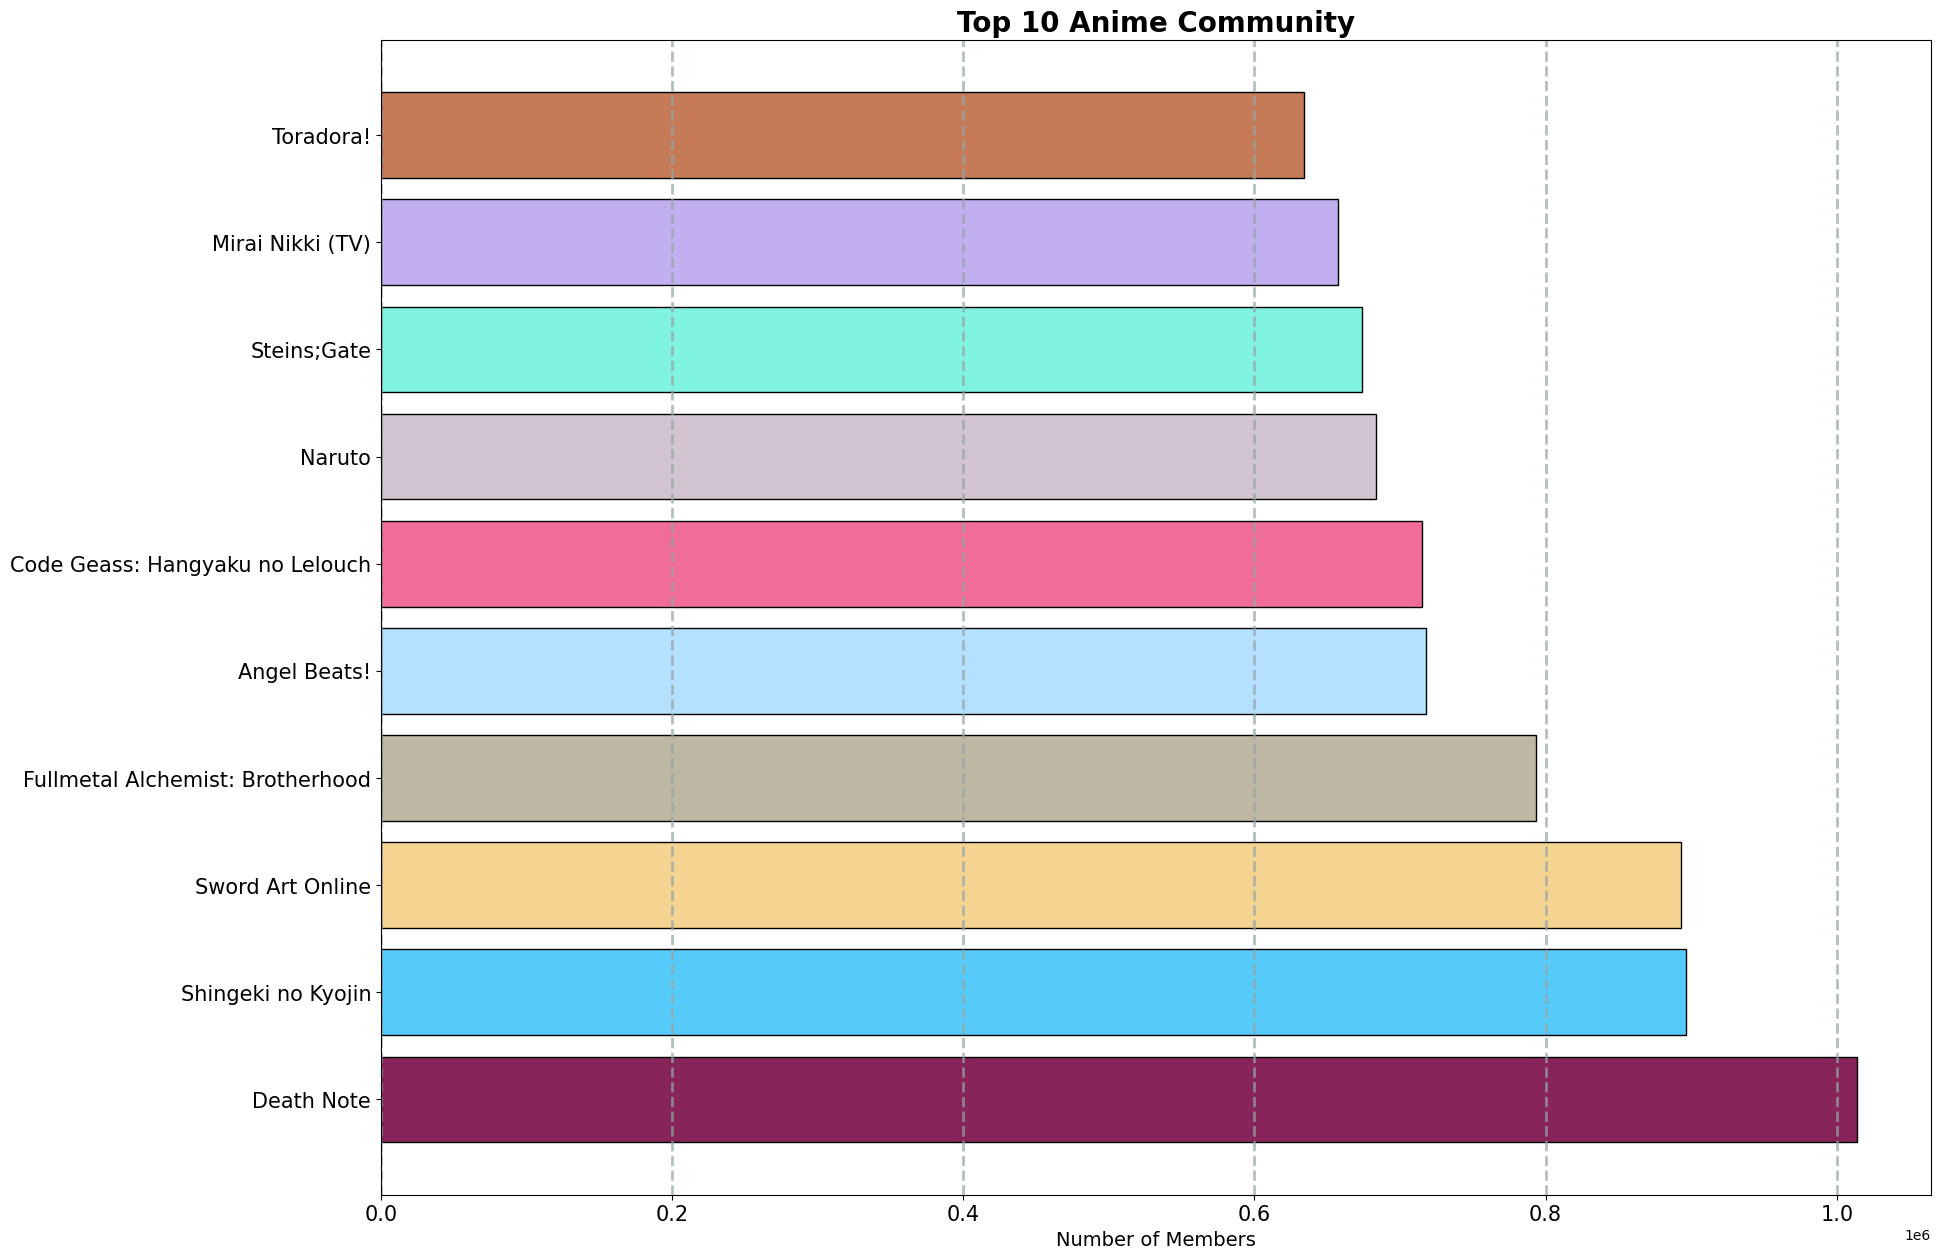

In [330]:
plt.figure(figsize = (20,15))
top10_anime = anime[['name', 'members']].sort_values(by = 'members',ascending = False).head(10)

colors = ['#87255B', '#56CBF9', '#F5D491', '#BEB7A4', '#B4E1FF', '#F06C9B', '#D3C4D1', '#81F4E1', '#C2AFF0', '#C57B57']

labels = top10_anime[['name']].values.flatten()
values = top10_anime[['members']].values.flatten()

plt.barh(labels, values, color = colors, edgecolor='black')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.7)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Top 10 Anime Community", fontdict = {'fontsize' : 20, 'fontweight': 'bold'})
plt.xlabel('Number of Members', fontsize=14)
plt.show()


### 7.5 Top 10 Anime by Average Rating


In [331]:
top10_anime_rating = anime.sort_values(by='rating', ascending=False).head(10)
print("Top 10 Anime by Average Rating:")
display(top10_anime_rating[['name', 'rating', 'members', 'type']])


Top 10 Anime by Average Rating:


,name,rating,members,type
10464,Taka no Tsume 8: Yoshida-kun no X-Files,10.00,13,Movie
10400,Spoon-hime no Swing Kitchen,9.60,47,TV
9595,Mogura no Motoro,9.50,62,Movie
0,Kimi no Na wa.,9.37,200630,Movie
9078,Kahei no Umi,9.33,44,Movie
1,Fullmetal Alchemist: Brotherhood,9.26,793665,TV
10786,Yakusoku: Africa Mizu to Midori,9.25,53,OVA
2,Gintama°,9.25,114262,TV
3,Steins;Gate,9.17,673572,TV
4,Gintama,9.16,151266,TV


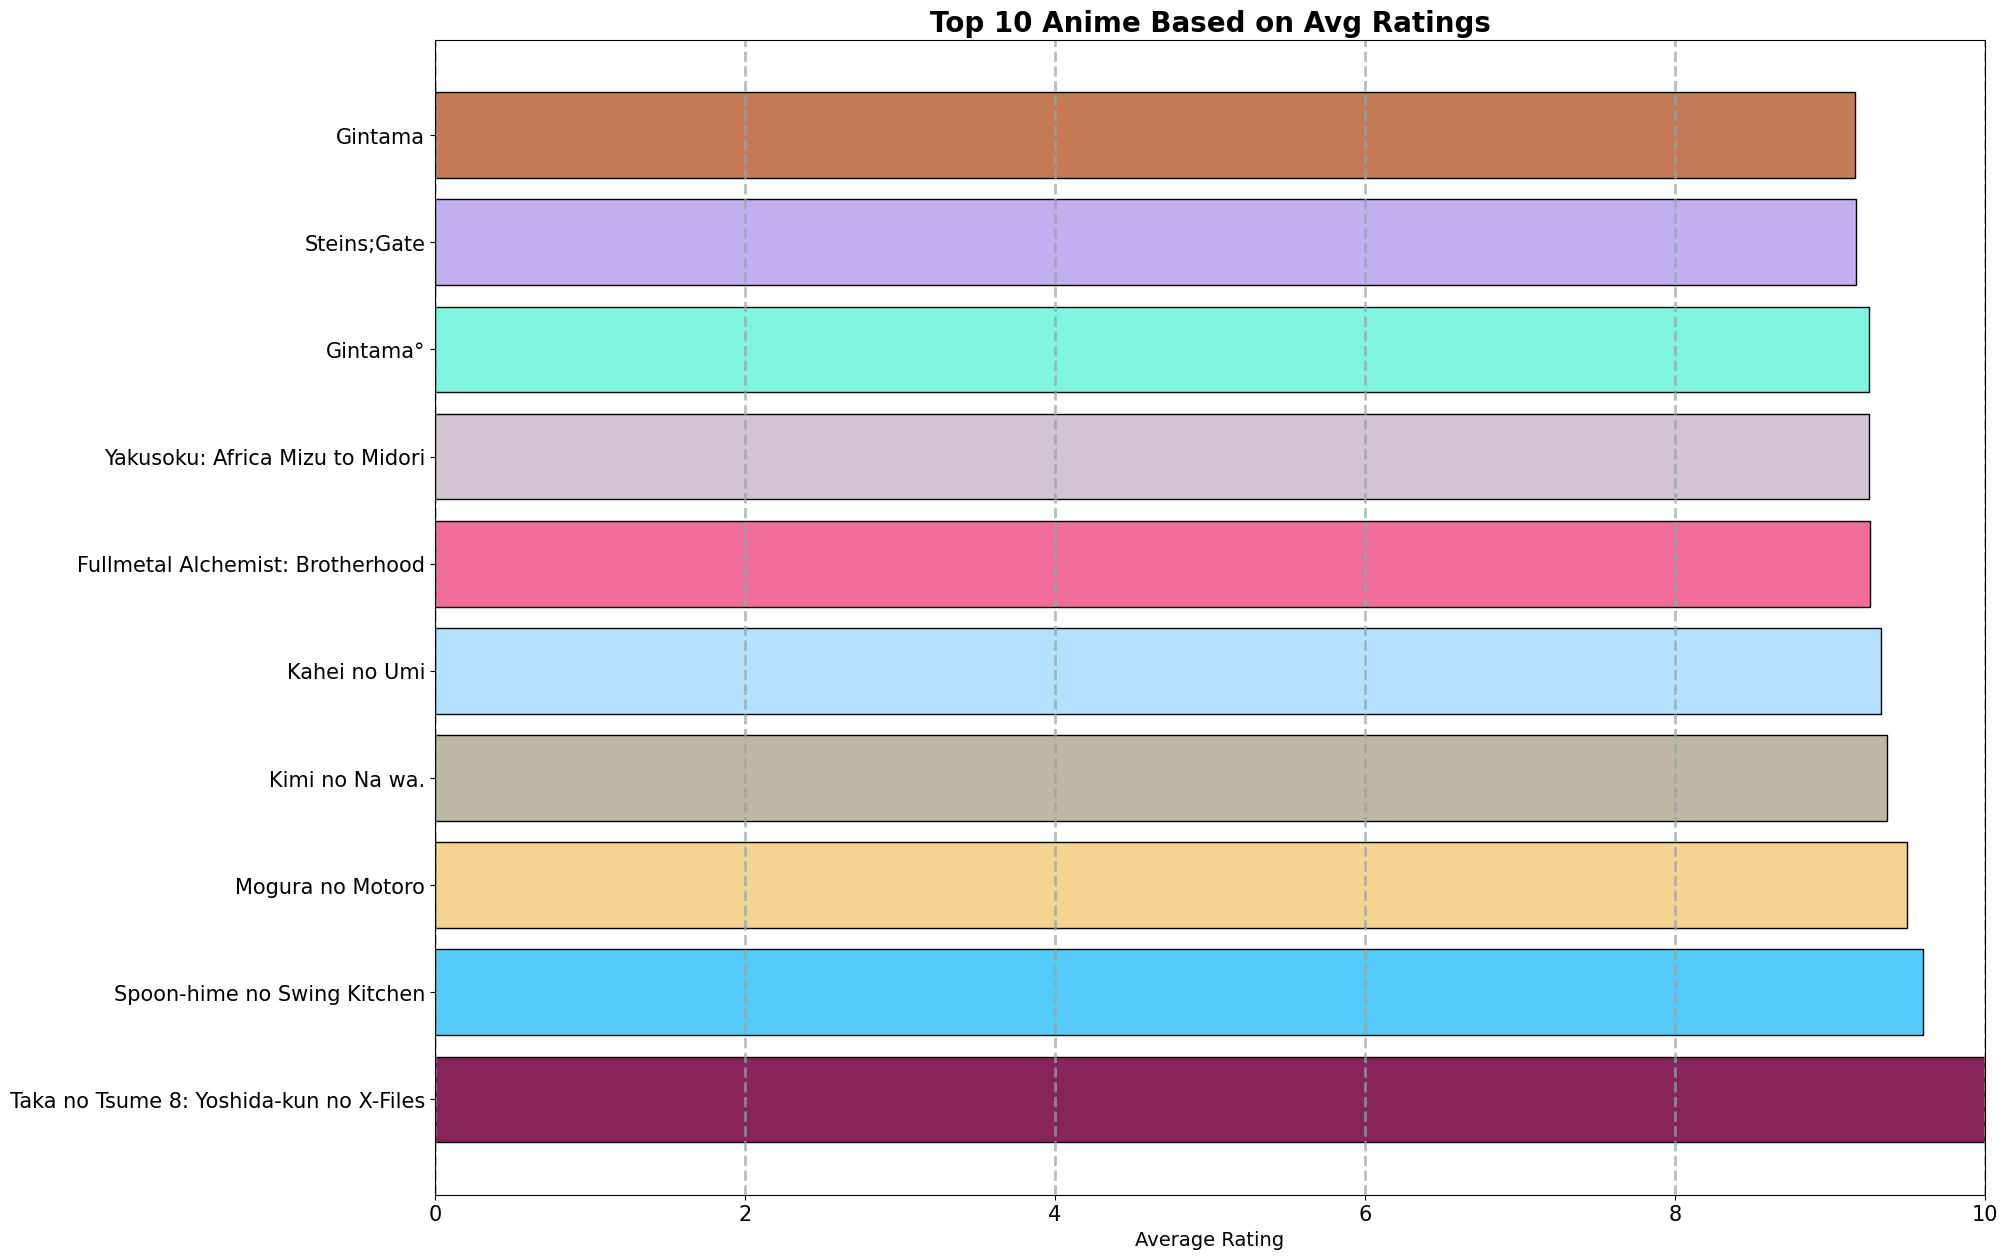

In [332]:
plt.figure(figsize = (20,15))
top10_anime = anime[['name', 'rating']].sort_values(by = 'rating',ascending = False).head(10)

colors = ['#87255B', '#56CBF9', '#F5D491', '#BEB7A4', '#B4E1FF', '#F06C9B', '#D3C4D1', '#81F4E1', '#C2AFF0', '#C57B57']

labels = top10_anime[['name']].values.flatten()
values = top10_anime[['rating']].values.flatten()

plt.barh(labels, values, color = colors, edgecolor='black')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.7)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Top 10 Anime Based on Avg Ratings", fontdict = {'fontsize' : 20, 'fontweight': 'bold'})
plt.xlabel('Average Rating', fontsize=14)
plt.xlim(0, 10)
plt.show()


### 7.6 Top 10 Anime by Rating Contribution


In [333]:
anime_rating_contribution = anime_rating.groupby('anime_id').count()
anime2 = anime.drop(['rating'], axis = 'columns')
name_anime_rating_contribution = pd.merge(anime_rating_contribution, anime2, on = 'anime_id', how = 'left')
top10_contribution = name_anime_rating_contribution.sort_values(by='rating', ascending=False).head(10)

print("Top 10 Anime by Rating Contribution:")
display(top10_contribution[['name', 'rating', 'members', 'type']])


Top 10 Anime by Rating Contribution:


,name,rating,members,type
1388,Death Note,34226,1013917.0,TV
6323,Sword Art Online,26310,893100.0,TV
7059,Shingeki no Kyojin,25289,896229.0,TV
1426,Code Geass: Hangyaku no Lelouch,24126,715151.0,TV
4567,Angel Beats!,23565,717796.0,TV
201,Elfen Lied,23528,623511.0,TV
10,Naruto,22071,683297.0,TV
3936,Fullmetal Alchemist: Brotherhood,21494,793665.0,TV
99,Fullmetal Alchemist,21332,600384.0,TV
2642,Code Geass: Hangyaku no Lelouch R2,21124,572888.0,TV


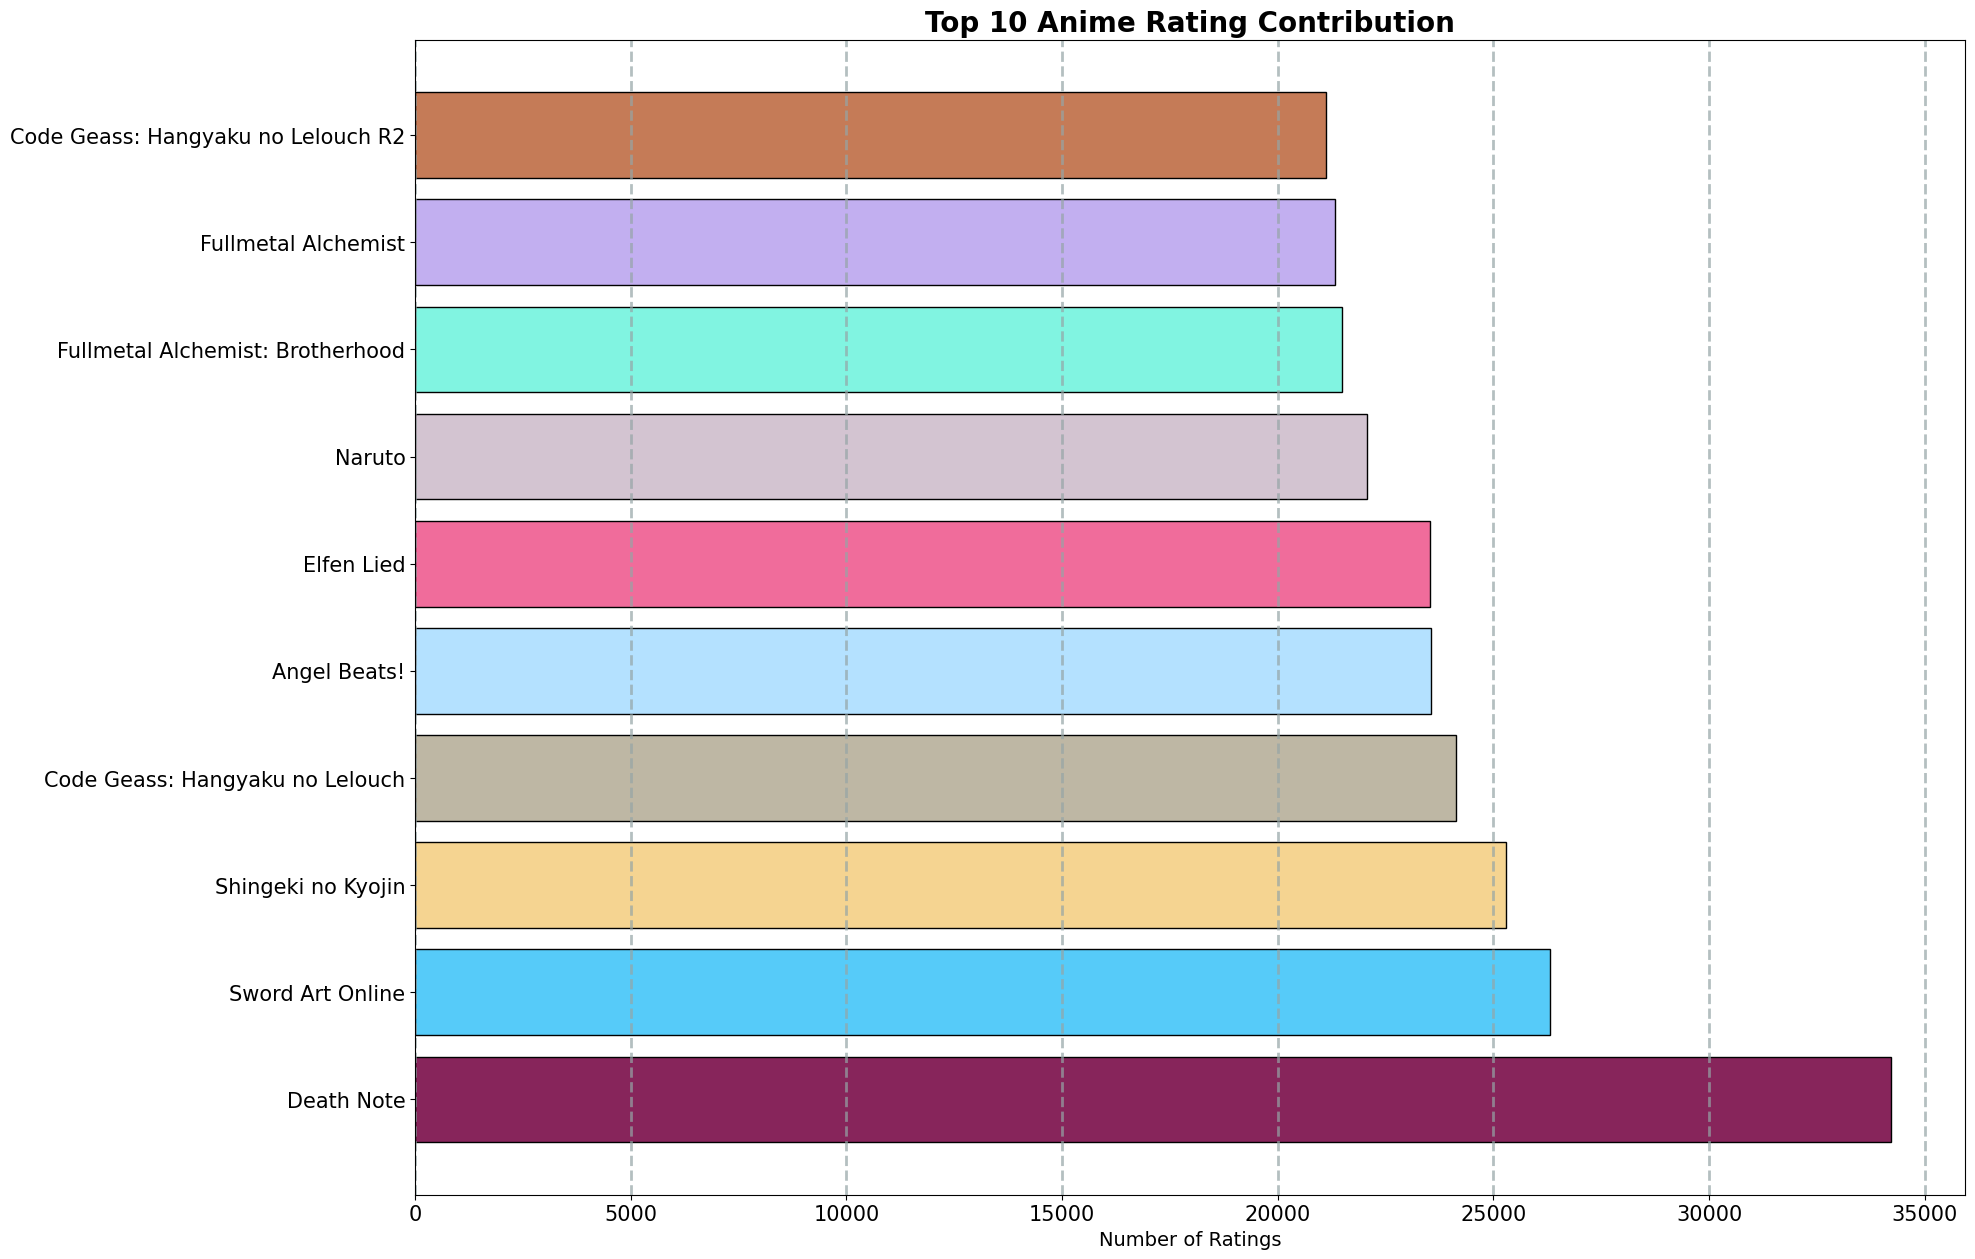

In [334]:
plt.figure(figsize = (20,15))
top10_anime = name_anime_rating_contribution[['name', 'rating']].sort_values(by = 'rating',ascending = False).head(10)

colors = ['#87255B', '#56CBF9', '#F5D491', '#BEB7A4', '#B4E1FF', '#F06C9B', '#D3C4D1', '#81F4E1', '#C2AFF0', '#C57B57']

labels = top10_anime[['name']].values.flatten()
values = top10_anime[['rating']].values.flatten()

plt.barh(labels, values, color = colors, edgecolor='black')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.7)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Top 10 Anime Rating Contribution", fontdict = {'fontsize' : 20, 'fontweight': 'bold'})
plt.xlabel('Number of Ratings', fontsize=14)
plt.show()


## 8. Content-Based Recommendation System

### 8.1 TF-IDF Vectorization


In [335]:
# Initialize TF-IDF Vectorizer
tf = TfidfVectorizer()
tf.fit(anime['genre']) 

print("TF-IDF Feature Names (first 20):")
print(tf.get_feature_names_out()[:20])
print(f"\nTotal features: {len(tf.get_feature_names_out())}")


TF-IDF Feature Names (first 20):
['action' 'adventure' 'ai' 'arts' 'cars' 'comedy' 'dementia' 'demons'
 'drama' 'ecchi' 'fantasy' 'fi' 'game' 'harem' 'hentai' 'historical'
 'horror' 'josei' 'kids' 'life']

Total features: 47


In [336]:
# Transform genre to TF-IDF matrix
tfidf_matrix = tf.fit_transform(anime['genre'])
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"Matrix type: {type(tfidf_matrix)}")


TF-IDF Matrix Shape: (12017, 47)
Matrix type: <class 'scipy.sparse._csr.csr_matrix'>


In [337]:
# Sample TF-IDF matrix (dense representation for visualization)
tfidf_sample = pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names_out(),
    index=anime.name
).sample(22, axis=1).sample(10, axis=0)

print("Sample TF-IDF Matrix (10 anime x 22 genres):")
display(tfidf_sample)


Sample TF-IDF Matrix (10 anime x 22 genres):


,thriller,samurai,josei,yaoi,historical,magic,game,psychological,mecha,ai,...,action,horror,demons,shounen,drama,yuri,school,dementia,police,adventure
name,,,,,,,,,,,,,,,,,,,,,
Accel World: Acchel World.,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
Hump Bang,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
Hi-Speed Jecy,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.532356,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
Redline,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.283708,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
Toaru Majutsu no Index: Endymion no Kiseki Special,0.0,0.0,0.0,0.0,0.0,0.443864,0.0,0.0,0.000000,0.0,...,0.290043,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
Haikyuu!! Movie 1: Owari to Hajimari,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.421568,0.403612,0.0,0.478326,0.0,0.000000,0.0
Machine Robo: Revenge of Chronos,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.608952,0.0,...,0.422268,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
Aru Hi Inu no Kuni kara Tegami ga Kite,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.581045,0.0,0.000000,0.0,0.000000,0.0
Ultra Dino Makera,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.633152,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0


### 8.2 Cosine Similarity Calculation


In [338]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix) 
print(f"Cosine Similarity Matrix Shape: {cosine_sim.shape}")
print(f"Similarity range: [{cosine_sim.min():.4f}, {cosine_sim.max():.4f}]")


Cosine Similarity Matrix Shape: (12017, 12017)
Similarity range: [0.0000, 1.0000]


In [339]:
# Convert to DataFrame for easier access
cosine_sim_df = pd.DataFrame(cosine_sim, index=anime['name'], columns=anime['name'])
print('Cosine Similarity DataFrame Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix sample
print("\nSample Similarity Matrix (10 anime x 5 anime):")
display(cosine_sim_df.sample(5, axis=1).sample(10, axis=0))


Cosine Similarity DataFrame Shape: (12017, 12017)

Sample Similarity Matrix (10 anime x 5 anime):


name,Umacha,Sirius no Densetsu,Maryuu Senki,Maro no Kanja wa Gatenkei,Detective Conan Movie 03: The Last Wizard of the Century
name,,,,,
Gift: Eternal Rainbow,0.0,0.427939,0.000000,0.0,0.058718
Jewelpet Movie: Sweets Dance Princess,0.0,0.237313,0.225649,0.0,0.000000
Hitsuji no Uta,0.0,0.201381,0.493007,0.0,0.000000
Major Movie: Yuujou no Winning Shot,0.0,0.000000,0.000000,0.0,0.191812
Uchuu Kaizoku Mito no Daibouken: Futari no Joou-sama,0.0,0.000000,0.000000,0.0,0.096419
Dirty Pair: Lovely Angels yori Ai wo Komete,0.0,0.000000,0.000000,0.0,0.608391
21 Emon Uchuu e Irasshai!,0.0,0.000000,0.000000,0.0,0.077594
Aru Zombie Shoujo no Sainan,0.0,0.000000,0.753405,0.0,0.000000
Koe no Katachi,0.0,0.301238,0.000000,0.0,0.205633


### 8.3 Recommendation Function


In [340]:
def anime_recommendations(name, similarity_data=cosine_sim_df, items=anime[['name', 'genre']], k=10):
    """
    Fungsi untuk memberikan rekomendasi anime berdasarkan similarity
    
    Parameters:
    -----------
    name : str
        Nama anime yang ingin dicari rekomendasinya
    similarity_data : DataFrame
        DataFrame berisi cosine similarity matrix
    items : DataFrame
        DataFrame berisi informasi anime (name, genre)
    k : int
        Jumlah rekomendasi yang ingin ditampilkan
    
    Returns:
    --------
    DataFrame
        DataFrame berisi k rekomendasi anime
    """
    # Cek apakah anime ada dalam dataset
    if name not in similarity_data.index:
        print(f"Anime '{name}' tidak ditemukan dalam dataset.")
        return pd.DataFrame()
    
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,name].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # Drop name agar nama anime yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(name, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

print("Recommendation function created!")


Recommendation function created!


### 8.4 Testing Recommendation System


In [341]:
# Test 1: Dragon Ball Z
anime_name = 'Dragon Ball Z'
print(f"=== Rekomendasi untuk: {anime_name} ===\n")

# Cek apakah anime ada
anime_info = anime[anime.name.eq(anime_name)]
if len(anime_info) > 0:
    print("Anime Info:")
    display(anime_info[['name', 'genre', 'type', 'rating', 'members']])
    print("\nRekomendasi:")
    recommendations = anime_recommendations(anime_name)
    display(recommendations)
else:
    print(f"Anime '{anime_name}' tidak ditemukan.")


=== Rekomendasi untuk: Dragon Ball Z ===

Anime Info:


,name,genre,type,rating,members
206,Dragon Ball Z,"Action, Adventure, Comedy, Fantasy, Martial Ar...",TV,8.32,375662



Rekomendasi:


,name,genre
0,Dragon Ball Z: Atsumare! Gokuu World,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
1,Dragon Ball Super,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
2,Dragon Ball GT: Goku Gaiden! Yuuki no Akashi w...,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
3,Dragon Ball Z Movie 11: Super Senshi Gekiha!! ...,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
4,Dragon Ball Z: Summer Vacation Special,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
5,Dragon Ball Kai,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
6,Dragon Ball Z Movie 15: Fukkatsu no F,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
7,Dragon Ball Kai (2014),"Action, Adventure, Comedy, Fantasy, Martial Ar..."
8,Dragon Ball Z Movie 14: Kami to Kami,"Action, Adventure, Fantasy, Martial Arts, Shou..."
9,Dragon Ball,"Adventure, Comedy, Fantasy, Martial Arts, Shou..."


In [342]:
# Test 2: Shingeki no Kyojin
anime_name = 'Shingeki no Kyojin'
print(f"=== Rekomendasi untuk: {anime_name} ===\n")

anime_info = anime[anime.name.eq(anime_name)]
if len(anime_info) > 0:
    print("Anime Info:")
    display(anime_info[['name', 'genre', 'type', 'rating', 'members']])
    print("\nRekomendasi:")
    recommendations = anime_recommendations(anime_name)
    display(recommendations)
else:
    print(f"Anime '{anime_name}' tidak ditemukan.")


=== Rekomendasi untuk: Shingeki no Kyojin ===

Anime Info:


,name,genre,type,rating,members
86,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,8.54,896229



Rekomendasi:


,name,genre
0,Shingeki no Kyojin Movie 1: Guren no Yumiya,"Action, Drama, Fantasy, Shounen, Super Power"
1,Shingeki no Kyojin Movie 2: Jiyuu no Tsubasa,"Action, Drama, Fantasy, Shounen, Super Power"
2,Shingeki no Kyojin: Ano Hi Kara,"Action, Drama, Fantasy, Shounen, Super Power"
3,Shingeki no Kyojin OVA,"Action, Drama, Fantasy, Shounen, Super Power"
4,Saint Seiya: Meiou Hades Elysion-hen,"Action, Fantasy, Shounen, Super Power"
5,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
6,One Piece: Episode of Sabo - 3 Kyoudai no Kizu...,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
7,One Piece: Episode of Nami - Koukaishi no Nami...,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
8,One Piece: Romance Dawn,"Action, Comedy, Fantasy, Shounen, Super Power"
9,One Piece: Episode of Merry - Mou Hitori no Na...,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."


In [343]:
# Test 3: Pokemon
anime_name = 'Pokemon'
print(f"=== Rekomendasi untuk: {anime_name} ===\n")

anime_info = anime[anime.name.eq(anime_name)]
if len(anime_info) > 0:
    print("Anime Info:")
    display(anime_info[['name', 'genre', 'type', 'rating', 'members']])
    print("\nRekomendasi:")
    recommendations = anime_recommendations(anime_name)
    display(recommendations)
else:
    print(f"Anime '{anime_name}' tidak ditemukan.")


=== Rekomendasi untuk: Pokemon ===

Anime Info:


,name,genre,type,rating,members
1834,Pokemon,"Action, Adventure, Comedy, Fantasy, Kids",TV,7.43,229157



Rekomendasi:


,name,genre
0,Pokemon Diamond and Pearl,"Action, Adventure, Comedy, Fantasy, Kids"
1,Digimon Universe: Appli Monsters,"Action, Adventure, Comedy, Fantasy, Kids"
2,Pokemon Best Wishes! Season 2: Decolora Advent...,"Action, Adventure, Comedy, Fantasy, Kids"
3,Pokemon Best Wishes! Season 2: Decolora Advent...,"Action, Adventure, Comedy, Fantasy, Kids"
4,Pokemon Crystal: Raikou Ikazuchi no Densetsu,"Action, Adventure, Comedy, Fantasy, Kids"
5,Pokemon: The Origin,"Action, Adventure, Comedy, Fantasy, Kids"
6,Pokemon XYandZ Specials,"Action, Adventure, Comedy, Fantasy, Kids"
7,Pokemon XY: Mega Evolution,"Action, Adventure, Comedy, Fantasy, Kids"
8,Pokemon Best Wishes! Season 2: Episode N,"Action, Adventure, Comedy, Fantasy, Kids"
9,Pokemon XY: New Year Special,"Action, Adventure, Comedy, Fantasy, Kids"


## 9. Model Evaluation

Evaluasi model Content-Based Filtering menggunakan beberapa metrik:
- **Precision@K**: Proporsi rekomendasi yang memiliki genre sama dengan anime target
- **Genre Overlap (Jaccard Similarity)**: Kesamaan set genre antara target dan rekomendasi
- **Average Cosine Similarity**: Rata-rata similarity score dari rekomendasi


### 9.1 Evaluation Functions


In [344]:
def calculate_jaccard_similarity(set1, set2):
    """
    Menghitung Jaccard Similarity antara dua set
    Jaccard = |A ∩ B| / |A ∪ B|
    """
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0

def evaluate_single_recommendation(anime_name, recommendations_df, anime_df, similarity_df, k=10):
    """
    Evaluasi rekomendasi untuk satu anime
    
    Parameters:
    -----------
    anime_name : str
        Nama anime target
    recommendations_df : DataFrame
        DataFrame hasil rekomendasi
    anime_df : DataFrame
        DataFrame anime dengan informasi lengkap
    similarity_df : DataFrame
        Cosine similarity matrix
    k : int
        Jumlah rekomendasi
    
    Returns:
    --------
    dict
        Dictionary berisi metrik evaluasi
    """
    if len(recommendations_df) == 0:
        return None
    
    # Ambil genre anime target
    target_genres = anime_df[anime_df['name'] == anime_name]['genre_list'].values
    if len(target_genres) == 0:
        return None
    target_genres = set(target_genres[0])
    
    # Metrics
    jaccard_scores = []
    precision_hits = []
    cosine_scores = []
    
    for idx, row in recommendations_df.iterrows():
        rec_name = row['name']
        
        # Ambil genre rekomendasi
        rec_genres = anime_df[anime_df['name'] == rec_name]['genre_list'].values
        if len(rec_genres) > 0:
            rec_genres = set(rec_genres[0])
            
            # Jaccard Similarity
            jaccard = calculate_jaccard_similarity(target_genres, rec_genres)
            jaccard_scores.append(jaccard)
            
            # Precision hit (ada minimal 1 genre yang sama)
            precision_hits.append(1 if len(target_genres & rec_genres) > 0 else 0)
        
        # Cosine Similarity
        if rec_name in similarity_df.columns and anime_name in similarity_df.index:
            cos_sim = similarity_df.loc[anime_name, rec_name]
            cosine_scores.append(cos_sim)
    
    return {
        'anime': anime_name,
        'num_recommendations': len(recommendations_df),
        'precision_at_k': np.mean(precision_hits) if precision_hits else 0,
        'avg_jaccard_similarity': np.mean(jaccard_scores) if jaccard_scores else 0,
        'avg_cosine_similarity': np.mean(cosine_scores) if cosine_scores else 0,
        'min_cosine_similarity': np.min(cosine_scores) if cosine_scores else 0,
        'max_cosine_similarity': np.max(cosine_scores) if cosine_scores else 0
    }

print("Evaluation functions created!")


Evaluation functions created!


### 9.2 Full Model Evaluation


In [345]:
# Daftar anime untuk evaluasi (campuran genre berbeda)
test_anime_list = [
    'Dragon Ball Z',
    'Shingeki no Kyojin',
    'Pokemon',
    'Naruto',
    'One Piece',
    'Death Note',
    'Sword Art Online',
    'Fullmetal Alchemist: Brotherhood',
    'Steins;Gate',
    'Hunter x Hunter (2011)',
    'Cowboy Bebop',
    'Code Geass: Hangyaku no Lelouch',
    'Toradora!',
    'Clannad',
    'Spirited Away'
]

# Filter hanya anime yang ada di dataset
available_test_anime = [name for name in test_anime_list if name in cosine_sim_df.index]
print(f"Anime yang tersedia untuk evaluasi: {len(available_test_anime)} dari {len(test_anime_list)}")
print(f"Anime: {available_test_anime}")


Anime yang tersedia untuk evaluasi: 14 dari 15
Anime: ['Dragon Ball Z', 'Shingeki no Kyojin', 'Pokemon', 'Naruto', 'One Piece', 'Death Note', 'Sword Art Online', 'Fullmetal Alchemist: Brotherhood', 'Steins;Gate', 'Hunter x Hunter (2011)', 'Cowboy Bebop', 'Code Geass: Hangyaku no Lelouch', 'Toradora!', 'Clannad']


In [346]:
# Evaluasi untuk setiap anime
k = 10  # Jumlah rekomendasi
evaluation_results = []

print("=" * 70)
print("EVALUASI MODEL CONTENT-BASED FILTERING")
print("=" * 70)

for anime_name in available_test_anime:
    # Dapatkan rekomendasi
    recommendations = anime_recommendations(anime_name, cosine_sim_df, anime[['name', 'genre']], k)
    
    # Evaluasi
    eval_result = evaluate_single_recommendation(
        anime_name, 
        recommendations, 
        anime, 
        cosine_sim_df, 
        k
    )
    
    if eval_result:
        evaluation_results.append(eval_result)
        print(f"\n📺 {anime_name}")
        print(f"   Precision@{k}: {eval_result['precision_at_k']:.2%}")
        print(f"   Avg Jaccard Similarity: {eval_result['avg_jaccard_similarity']:.4f}")
        print(f"   Avg Cosine Similarity: {eval_result['avg_cosine_similarity']:.4f}")

# Convert to DataFrame
evaluation_df = pd.DataFrame(evaluation_results)
print("\n" + "=" * 70)


EVALUASI MODEL CONTENT-BASED FILTERING

📺 Dragon Ball Z
   Precision@10: 100.00%
   Avg Jaccard Similarity: 0.9714
   Avg Cosine Similarity: 0.9956

📺 Shingeki no Kyojin
   Precision@10: 100.00%
   Avg Jaccard Similarity: 0.8324
   Avg Cosine Similarity: 0.9556

📺 Pokemon
   Precision@10: 100.00%
   Avg Jaccard Similarity: 1.0000
   Avg Cosine Similarity: 1.0000

📺 Naruto
   Precision@10: 100.00%
   Avg Jaccard Similarity: 0.9467
   Avg Cosine Similarity: 0.9928

📺 One Piece
   Precision@10: 100.00%
   Avg Jaccard Similarity: 0.9000
   Avg Cosine Similarity: 0.9634

📺 Death Note
   Precision@10: 100.00%
   Avg Jaccard Similarity: 0.6483
   Avg Cosine Similarity: 0.8394

📺 Sword Art Online
   Precision@10: 100.00%
   Avg Jaccard Similarity: 0.7333
   Avg Cosine Similarity: 0.8899

📺 Fullmetal Alchemist: Brotherhood
   Precision@10: 100.00%
   Avg Jaccard Similarity: 0.7518
   Avg Cosine Similarity: 0.8560

📺 Steins;Gate
   Precision@10: 100.00%
   Avg Jaccard Similarity: 0.6900
   Avg C

### 9.3 Evaluation Summary


In [347]:
# Tampilkan hasil evaluasi detail
print("=== HASIL EVALUASI DETAIL ===\n")
display(evaluation_df.round(4))

# Hitung rata-rata metrik
print("\n" + "=" * 70)
print("RINGKASAN EVALUASI MODEL")
print("=" * 70)
print(f"\n📊 Jumlah anime yang diuji: {len(evaluation_df)}")
print(f"\n📈 METRIK RATA-RATA:")
print(f"   • Mean Precision@{k}: {evaluation_df['precision_at_k'].mean():.2%}")
print(f"   • Mean Jaccard Similarity: {evaluation_df['avg_jaccard_similarity'].mean():.4f}")
print(f"   • Mean Cosine Similarity: {evaluation_df['avg_cosine_similarity'].mean():.4f}")
print(f"\n📉 RANGE COSINE SIMILARITY:")
print(f"   • Min Cosine Similarity: {evaluation_df['min_cosine_similarity'].min():.4f}")
print(f"   • Max Cosine Similarity: {evaluation_df['max_cosine_similarity'].max():.4f}")


=== HASIL EVALUASI DETAIL ===



,anime,num_recommendations,precision_at_k,avg_jaccard_similarity,avg_cosine_similarity,min_cosine_similarity,max_cosine_similarity
0,Dragon Ball Z,10,1.0,0.9714,0.9956,0.9733,1.0000
1,Shingeki no Kyojin,10,1.0,0.8324,0.9556,0.9093,1.0000
2,Pokemon,10,1.0,1.0000,1.0000,1.0000,1.0000
3,Naruto,10,1.0,0.9467,0.9928,0.9474,1.0000
4,One Piece,10,1.0,0.9000,0.9634,0.9477,1.0000
5,Death Note,10,1.0,0.6483,0.8394,0.7285,1.0000
6,Sword Art Online,10,1.0,0.7333,0.8899,0.8381,1.0000
7,Fullmetal Alchemist: Brotherhood,10,1.0,0.7518,0.8560,0.7848,0.9735
8,Steins;Gate,10,1.0,0.6900,0.8919,0.7841,1.0000
9,Hunter x Hunter (2011),10,1.0,0.9800,0.9968,0.9684,1.0000



RINGKASAN EVALUASI MODEL

📊 Jumlah anime yang diuji: 14

📈 METRIK RATA-RATA:
   • Mean Precision@10: 100.00%
   • Mean Jaccard Similarity: 0.8484
   • Mean Cosine Similarity: 0.9395

📉 RANGE COSINE SIMILARITY:
   • Min Cosine Similarity: 0.7285
   • Max Cosine Similarity: 1.0000


### 9.4 Evaluation Visualization


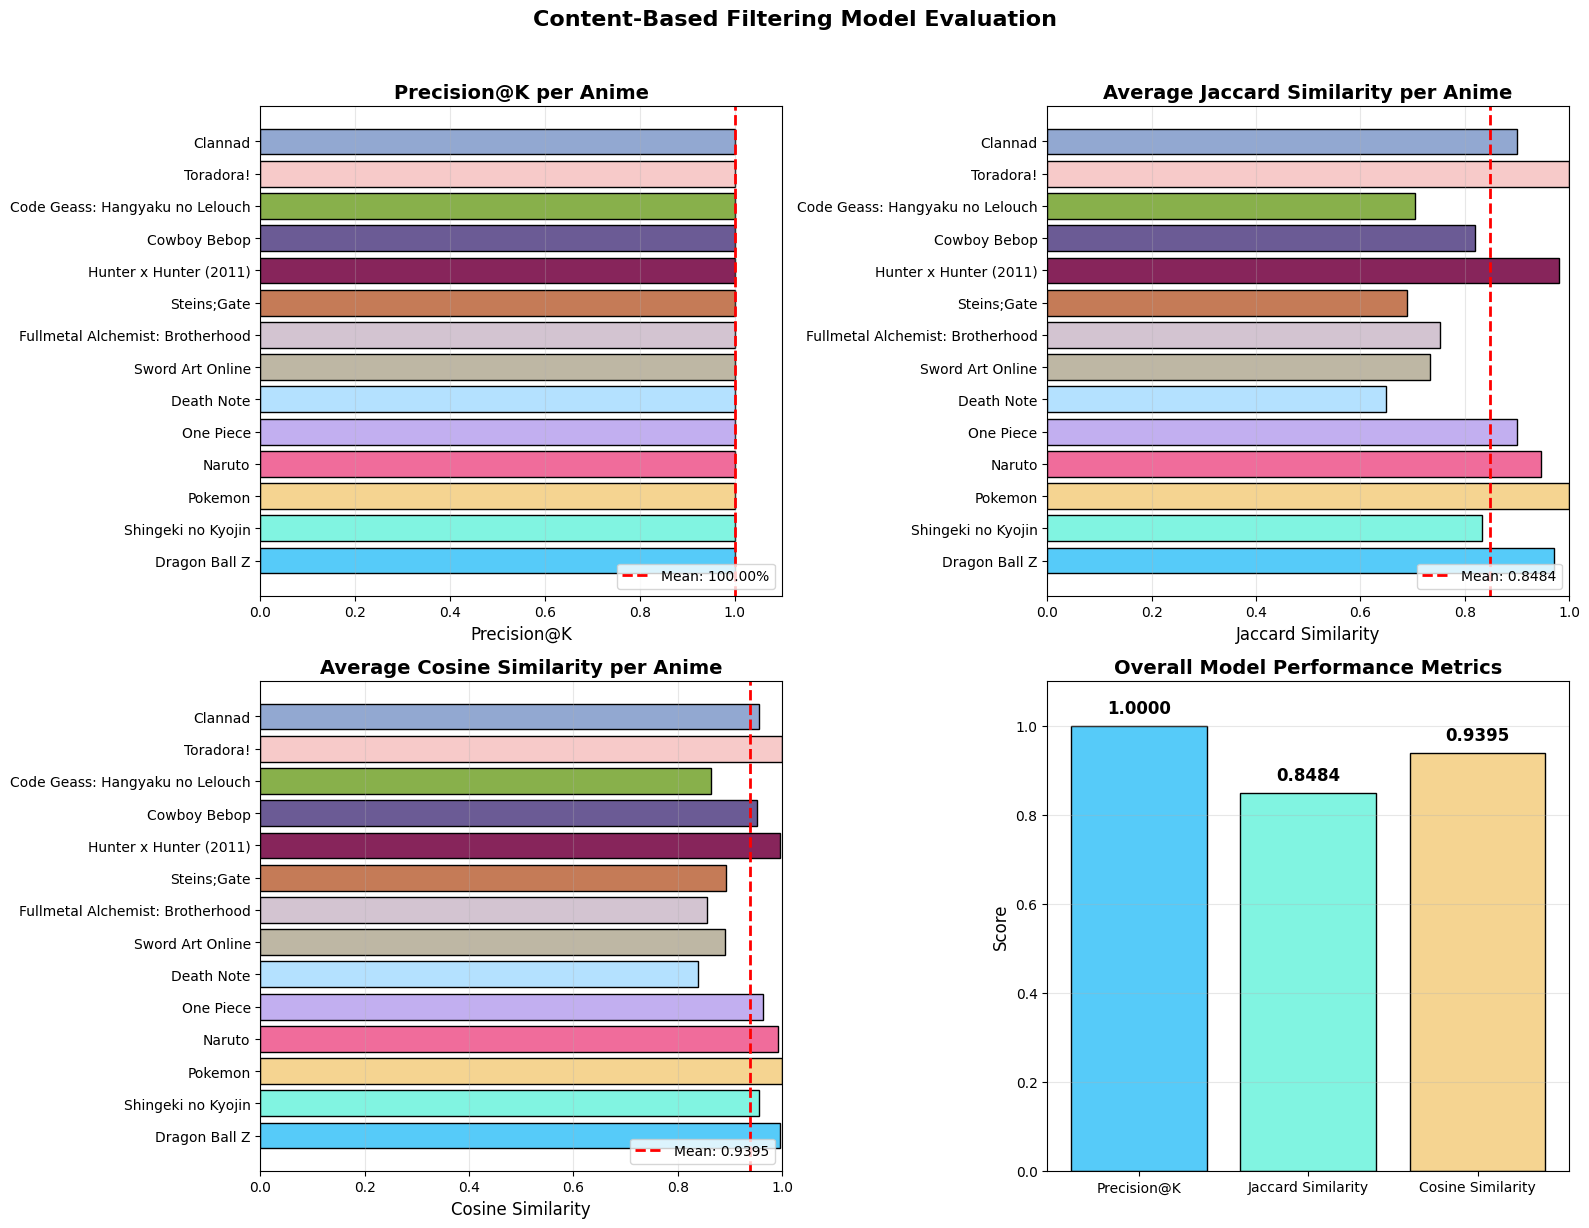

In [348]:
# Visualisasi hasil evaluasi
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Color palette
colors = ['#56CBF9', '#81F4E1', '#F5D491', '#F06C9B', '#C2AFF0', 
          '#B4E1FF', '#BEB7A4', '#D3C4D1', '#C57B57', '#87255B',
          '#6B5B95', '#88B04B', '#F7CAC9', '#92A8D1', '#955251']

# 1. Precision@K per anime
axes[0, 0].barh(evaluation_df['anime'], evaluation_df['precision_at_k'], 
                color=colors[:len(evaluation_df)], edgecolor='black')
axes[0, 0].axvline(x=evaluation_df['precision_at_k'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f"Mean: {evaluation_df['precision_at_k'].mean():.2%}")
axes[0, 0].set_xlabel('Precision@K', fontsize=12)
axes[0, 0].set_title('Precision@K per Anime', fontsize=14, fontweight='bold')
axes[0, 0].set_xlim(0, 1.1)
axes[0, 0].legend(loc='lower right')
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Jaccard Similarity per anime
axes[0, 1].barh(evaluation_df['anime'], evaluation_df['avg_jaccard_similarity'], 
                color=colors[:len(evaluation_df)], edgecolor='black')
axes[0, 1].axvline(x=evaluation_df['avg_jaccard_similarity'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f"Mean: {evaluation_df['avg_jaccard_similarity'].mean():.4f}")
axes[0, 1].set_xlabel('Jaccard Similarity', fontsize=12)
axes[0, 1].set_title('Average Jaccard Similarity per Anime', fontsize=14, fontweight='bold')
axes[0, 1].set_xlim(0, 1)
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Cosine Similarity per anime
axes[1, 0].barh(evaluation_df['anime'], evaluation_df['avg_cosine_similarity'], 
                color=colors[:len(evaluation_df)], edgecolor='black')
axes[1, 0].axvline(x=evaluation_df['avg_cosine_similarity'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f"Mean: {evaluation_df['avg_cosine_similarity'].mean():.4f}")
axes[1, 0].set_xlabel('Cosine Similarity', fontsize=12)
axes[1, 0].set_title('Average Cosine Similarity per Anime', fontsize=14, fontweight='bold')
axes[1, 0].set_xlim(0, 1)
axes[1, 0].legend(loc='lower right')
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Comparison of all metrics (aggregated)
metrics = ['Precision@K', 'Jaccard Similarity', 'Cosine Similarity']
values = [
    evaluation_df['precision_at_k'].mean(),
    evaluation_df['avg_jaccard_similarity'].mean(),
    evaluation_df['avg_cosine_similarity'].mean()
]
bars = axes[1, 1].bar(metrics, values, color=['#56CBF9', '#81F4E1', '#F5D491'], edgecolor='black')
axes[1, 1].set_ylabel('Score', fontsize=12)
axes[1, 1].set_title('Overall Model Performance Metrics', fontsize=14, fontweight='bold')
axes[1, 1].set_ylim(0, 1.1)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, values):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                    f'{val:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.suptitle('Content-Based Filtering Model Evaluation', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 9.5 Detailed Recommendation Analysis


In [349]:
# Analisis detail untuk satu anime (contoh)
sample_anime = 'Death Note'

if sample_anime in cosine_sim_df.index:
    print(f"=== ANALISIS DETAIL: {sample_anime} ===\n")
    
    # Info anime target
    target_info = anime[anime['name'] == sample_anime][['name', 'genre', 'type', 'rating', 'members']]
    print("📺 Anime Target:")
    display(target_info)
    
    target_genres = anime[anime['name'] == sample_anime]['genre_list'].values[0]
    print(f"\n🏷️ Genre: {target_genres}")
    
    # Dapatkan rekomendasi
    recs = anime_recommendations(sample_anime, cosine_sim_df, anime[['name', 'genre']], k=10)
    
    print(f"\n📋 Top 10 Rekomendasi:")
    
    # Tambahkan informasi similarity ke rekomendasi
    rec_details = []
    for idx, row in recs.iterrows():
        rec_name = row['name']
        rec_genre = row['genre']
        rec_genres_list = anime[anime['name'] == rec_name]['genre_list'].values
        
        if len(rec_genres_list) > 0:
            rec_genres_set = set(rec_genres_list[0])
            target_genres_set = set(target_genres)
            
            # Hitung metrics
            cos_sim = cosine_sim_df.loc[sample_anime, rec_name]
            jaccard = calculate_jaccard_similarity(target_genres_set, rec_genres_set)
            common_genres = target_genres_set & rec_genres_set
            
            rec_details.append({
                'Anime': rec_name,
                'Genre': rec_genre,
                'Cosine Similarity': cos_sim,
                'Jaccard Similarity': jaccard,
                'Common Genres': ', '.join(common_genres) if common_genres else 'None'
            })
    
    rec_details_df = pd.DataFrame(rec_details)
    display(rec_details_df)
else:
    print(f"Anime '{sample_anime}' tidak ditemukan dalam dataset.")


=== ANALISIS DETAIL: Death Note ===

📺 Anime Target:


,name,genre,type,rating,members
40,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,8.71,1013917



🏷️ Genre: ['Mystery', 'Police', 'Psychological', 'Supernatural', 'Thriller']

📋 Top 10 Rekomendasi:


,Anime,Genre,Cosine Similarity,Jaccard Similarity,Common Genres
0,Death Note Rewrite,"Mystery, Police, Psychological, Supernatural, ...",1.000000,1.000000,"Mystery, Supernatural, Psychological, Thriller..."
1,Mousou Dairinin,"Drama, Mystery, Police, Psychological, Superna...",0.967697,0.833333,"Mystery, Supernatural, Psychological, Thriller..."
2,Higurashi no Naku Koro ni Kai,"Mystery, Psychological, Supernatural, Thriller",0.879823,0.800000,"Psychological, Thriller, Mystery, Supernatural"
3,Higurashi no Naku Koro ni Rei,"Comedy, Mystery, Psychological, Supernatural, ...",0.861463,0.666667,"Psychological, Thriller, Mystery, Supernatural"
4,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",0.815640,0.571429,"Psychological, Thriller, Mystery, Supernatural"
5,Mirai Nikki (TV): Ura Mirai Nikki,"Action, Comedy, Mystery, Psychological, Shoune...",0.800948,0.500000,"Psychological, Thriller, Mystery, Supernatural"
6,Higurashi no Naku Koro ni,"Horror, Mystery, Psychological, Supernatural, ...",0.794679,0.666667,"Psychological, Thriller, Mystery, Supernatural"
7,Monster,"Drama, Horror, Mystery, Police, Psychological,...",0.790012,0.500000,"Psychological, Thriller, Mystery, Police"
8,AD Police,"Adventure, Dementia, Mecha, Mystery, Police, P...",0.754805,0.444444,"Psychological, Thriller, Mystery, Police"
9,Higurashi no Naku Koro ni Kaku: Outbreak,"Horror, Mystery, Psychological, Thriller",0.728504,0.500000,"Psychological, Thriller, Mystery"


### 9.6 Model Interpretation


In [350]:
# Interpretasi hasil evaluasi
print("=" * 70)
print("INTERPRETASI HASIL EVALUASI MODEL")
print("=" * 70)

avg_precision = evaluation_df['precision_at_k'].mean()
avg_jaccard = evaluation_df['avg_jaccard_similarity'].mean()
avg_cosine = evaluation_df['avg_cosine_similarity'].mean()

print(f"""
📊 HASIL EVALUASI:

1. PRECISION@{k} = {avg_precision:.2%}
   → Artinya {avg_precision*100:.1f}% dari rekomendasi memiliki minimal 1 genre yang sama 
     dengan anime target.
   → Interpretasi: {"Sangat Baik" if avg_precision >= 0.9 else "Baik" if avg_precision >= 0.7 else "Cukup" if avg_precision >= 0.5 else "Perlu Perbaikan"}

2. JACCARD SIMILARITY = {avg_jaccard:.4f}
   → Mengukur kesamaan set genre (intersection/union)
   → Nilai {avg_jaccard:.2%} menunjukkan tingkat overlap genre antara target dan rekomendasi
   → Interpretasi: {"Tinggi" if avg_jaccard >= 0.5 else "Sedang" if avg_jaccard >= 0.3 else "Rendah"}

3. COSINE SIMILARITY = {avg_cosine:.4f}
   → Mengukur kesamaan vektor TF-IDF
   → Semakin mendekati 1, semakin mirip genre-nya
   → Interpretasi: {"Sangat Mirip" if avg_cosine >= 0.8 else "Mirip" if avg_cosine >= 0.6 else "Cukup Mirip" if avg_cosine >= 0.4 else "Kurang Mirip"}

📝 KESIMPULAN:
   Model Content-Based Filtering berhasil memberikan rekomendasi anime
   dengan genre yang {"sangat relevan" if avg_precision >= 0.9 else "relevan" if avg_precision >= 0.7 else "cukup relevan" if avg_precision >= 0.5 else "kurang relevan"} dengan anime target.
   
   Kelebihan:
   - Tidak memerlukan data rating user (cold start friendly untuk user baru)
   - Rekomendasi transparan (berdasarkan kesamaan genre)
   
   Keterbatasan:
   - Hanya berdasarkan genre, tidak mempertimbangkan preferensi personal user
   - Tidak bisa merekomendasikan anime dengan genre yang berbeda tapi mungkin disukai
""")


INTERPRETASI HASIL EVALUASI MODEL

📊 HASIL EVALUASI:

1. PRECISION@10 = 100.00%
   → Artinya 100.0% dari rekomendasi memiliki minimal 1 genre yang sama 
     dengan anime target.
   → Interpretasi: Sangat Baik

2. JACCARD SIMILARITY = 0.8484
   → Mengukur kesamaan set genre (intersection/union)
   → Nilai 84.84% menunjukkan tingkat overlap genre antara target dan rekomendasi
   → Interpretasi: Tinggi

3. COSINE SIMILARITY = 0.9395
   → Mengukur kesamaan vektor TF-IDF
   → Semakin mendekati 1, semakin mirip genre-nya
   → Interpretasi: Sangat Mirip

📝 KESIMPULAN:
   Model Content-Based Filtering berhasil memberikan rekomendasi anime
   dengan genre yang sangat relevan dengan anime target.

   Kelebihan:
   - Tidak memerlukan data rating user (cold start friendly untuk user baru)
   - Rekomendasi transparan (berdasarkan kesamaan genre)

   Keterbatasan:
   - Hanya berdasarkan genre, tidak mempertimbangkan preferensi personal user
   - Tidak bisa merekomendasikan anime dengan genre yang b

### 9.7 User-Based Evaluation (Precision, Recall, F1-Score)

Evaluasi berdasarkan data rating user untuk menghitung metrik klasifikasi:
- **Precision**: Dari rekomendasi yang diberikan, berapa yang benar-benar relevan (user rating tinggi)
- **Recall**: Dari anime yang user suka, berapa yang berhasil direkomendasikan
- **F1-Score**: Harmonic mean dari Precision dan Recall
- **Accuracy**: Proporsi prediksi yang benar


In [351]:
# Persiapan data untuk evaluasi berbasis user
# Merge anime_rating dengan anime untuk mendapatkan nama anime
anime_rating_with_name = anime_rating.merge(
    anime[['anime_id', 'name']], 
    on='anime_id', 
    how='inner'
)

print(f"Rating data with anime names: {len(anime_rating_with_name):,} records")
print(f"Unique users: {anime_rating_with_name['user_id'].nunique():,}")
print(f"Unique anime: {anime_rating_with_name['name'].nunique():,}")

# Filter hanya anime yang ada di cosine_sim_df
anime_rating_filtered = anime_rating_with_name[
    anime_rating_with_name['name'].isin(cosine_sim_df.index)
]
print(f"\nAfter filtering (anime in similarity matrix): {len(anime_rating_filtered):,} records")


Rating data with anime names: 6,337,145 records
Unique users: 69,600
Unique anime: 9,887

After filtering (anime in similarity matrix): 6,337,145 records


In [355]:
def safe_anime_recommendations(name, similarity_data, items, k=10):
    """
    Fungsi rekomendasi yang aman dari error bounds
    """
    # Cek apakah anime ada dalam dataset
    if name not in similarity_data.index:
        return pd.DataFrame()
    
    # Ambil similarity scores untuk anime ini
    sim_scores = similarity_data.loc[:, name]
    
    # Pastikan k tidak melebihi jumlah anime yang tersedia
    available_k = min(k + 1, len(sim_scores))  # +1 untuk exclude diri sendiri
    
    if available_k <= 1:
        return pd.DataFrame()
    
    # Ambil top-k anime dengan similarity tertinggi
    top_indices = sim_scores.nlargest(available_k).index.tolist()
    
    # Hapus anime itu sendiri dari list
    if name in top_indices:
        top_indices.remove(name)
    
    # Ambil k teratas
    closest = top_indices[:k]
    
    if len(closest) == 0:
        return pd.DataFrame()
    
    return pd.DataFrame({'name': closest}).merge(items).head(k)

def evaluate_user_recommendations(user_id, user_anime_df, similarity_df, anime_df, 
                                   rating_threshold=7, k=10, train_ratio=0.7):
    """
    Evaluasi rekomendasi untuk satu user dengan Precision, Recall, F1-Score
    
    Parameters:
    -----------
    user_id : int
        ID user
    user_anime_df : DataFrame
        DataFrame berisi anime yang sudah ditonton user dengan rating
    similarity_df : DataFrame
        Cosine similarity matrix
    anime_df : DataFrame
        DataFrame anime
    rating_threshold : int
        Threshold rating untuk dianggap "liked" (default 7)
    k : int
        Jumlah rekomendasi
    train_ratio : float
        Rasio data training
    
    Returns:
    --------
    dict
        Dictionary berisi metrik evaluasi
    """
    try:
        # Filter anime user ini
        user_data = user_anime_df[user_anime_df['user_id'] == user_id].copy()
        
        if len(user_data) < 5:  # Minimal 5 anime untuk evaluasi
            return None
        
        # Shuffle dan split data
        user_data = user_data.sample(frac=1, random_state=42)
        split_idx = int(len(user_data) * train_ratio)
        
        train_data = user_data.iloc[:split_idx]
        test_data = user_data.iloc[split_idx:]
        
        if len(train_data) == 0 or len(test_data) == 0:
            return None
        
        # Anime yang disukai user di test set (ground truth)
        test_liked = set(test_data[test_data['rating'] >= rating_threshold]['name'].tolist())
        test_not_liked = set(test_data[test_data['rating'] < rating_threshold]['name'].tolist())
        
        if len(test_liked) == 0:
            return None
        
        # Generate rekomendasi berdasarkan train data
        train_anime_names = train_data['name'].tolist()
        
        # Ambil rekomendasi berdasarkan anime yang sudah ditonton
        all_recommendations = set()
        for anime_name in train_anime_names:
            if anime_name in similarity_df.index:
                # Gunakan fungsi yang aman
                recs = safe_anime_recommendations(anime_name, similarity_df, anime_df[['name', 'genre']], k=k)
                if len(recs) > 0:
                    all_recommendations.update(recs['name'].tolist())
    
        # Hapus anime yang sudah ditonton dari rekomendasi
        all_recommendations = all_recommendations - set(train_anime_names)
        
        if len(all_recommendations) == 0:
            return None
        
        # Hitung metrik
        # True Positives: Rekomendasi yang ada di test_liked
        tp = len(all_recommendations & test_liked)
        # False Positives: Rekomendasi yang ada di test_not_liked atau tidak ada di test
        fp = len(all_recommendations - test_liked)
        # False Negatives: Anime liked yang tidak direkomendasikan
        fn = len(test_liked - all_recommendations)
        # True Negatives: Anime not liked yang tidak direkomendasikan
        tn = len(test_not_liked - all_recommendations)
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        
        return {
            'user_id': user_id,
            'train_size': len(train_data),
            'test_size': len(test_data),
            'test_liked': len(test_liked),
            'recommendations': len(all_recommendations),
            'true_positives': tp,
            'false_positives': fp,
            'false_negatives': fn,
            'true_negatives': tn,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'accuracy': accuracy
        }
    except Exception as e:
        # Skip user jika ada error
        return None

print("User evaluation function created!")


User evaluation function created!


In [356]:
# Pilih sample users untuk evaluasi (user dengan banyak rating)
user_rating_counts = anime_rating_filtered.groupby('user_id').size()
active_users = user_rating_counts[user_rating_counts >= 50].index.tolist()

print(f"Total active users (≥50 ratings): {len(active_users):,}")

# Sample 100 users untuk evaluasi (bisa diubah sesuai kebutuhan)
np.random.seed(42)
sample_users = np.random.choice(active_users, size=min(100, len(active_users)), replace=False)
print(f"Sampled users for evaluation: {len(sample_users)}")


Total active users (≥50 ratings): 32,967
Sampled users for evaluation: 100


In [358]:
# Evaluasi untuk setiap sample user
print("=" * 70)
print("EVALUASI BERBASIS USER (Precision, Recall, F1-Score)")
print("=" * 70)
print("\nMengevaluasi rekomendasi untuk sample users...")

user_eval_results = []
# Batasi hanya 20-30 users untuk evaluasi lebih cepat
max_users = min(30, len(sample_users))  # Ubah angka ini sesuai kebutuhan

for i, user_id in enumerate(sample_users[:max_users]):
    result = evaluate_user_recommendations(
        user_id=user_id,
        user_anime_df=anime_rating_filtered,
        similarity_df=cosine_sim_df,
        anime_df=anime,
        rating_threshold=7,
        k=10,
        train_ratio=0.7
    )
    if result:
        user_eval_results.append(result)
    
    # Progress indicator setiap 5 users
    if (i + 1) % 5 == 0:
        print(f"  Processed {i + 1}/{max_users} users...")

print(f"\nEvaluasi selesai! {len(user_eval_results)} users berhasil dievaluasi.")

EVALUASI BERBASIS USER (Precision, Recall, F1-Score)

Mengevaluasi rekomendasi untuk sample users...
  Processed 5/30 users...
  Processed 10/30 users...
  Processed 15/30 users...
  Processed 20/30 users...
  Processed 25/30 users...
  Processed 30/30 users...

Evaluasi selesai! 22 users berhasil dievaluasi.


In [359]:
# Convert hasil ke DataFrame
user_eval_df = pd.DataFrame(user_eval_results)

# Tampilkan sample hasil
print("=== SAMPLE HASIL EVALUASI PER USER ===\n")
display(user_eval_df[['user_id', 'train_size', 'test_size', 'precision', 'recall', 'f1_score', 'accuracy']].head(10).round(4))


=== SAMPLE HASIL EVALUASI PER USER ===



,user_id,train_size,test_size,precision,recall,f1_score,accuracy
0,20305,51,23,0.0306,0.5000,0.0576,0.0323
1,59627,50,22,0.0251,0.4091,0.0474,0.0243
2,44359,38,17,0.0118,0.2143,0.0224,0.0150
3,21504,140,60,0.0396,0.5763,0.0741,0.0395
4,9091,214,92,0.0332,0.6212,0.0631,0.0440
5,43690,72,32,0.0232,0.5000,0.0444,0.0336
6,6072,70,31,0.0113,0.2000,0.0214,0.0126
7,7974,128,55,0.0115,0.2115,0.0219,0.0131
8,45209,82,36,0.0272,0.4688,0.0515,0.0315
9,15290,97,42,0.0287,0.5714,0.0547,0.0349


### 9.8 Classification Metrics Summary


In [360]:
# Ringkasan metrik klasifikasi
print("=" * 70)
print("RINGKASAN METRIK KLASIFIKASI")
print("=" * 70)

mean_precision = user_eval_df['precision'].mean()
mean_recall = user_eval_df['recall'].mean()
mean_f1 = user_eval_df['f1_score'].mean()
mean_accuracy = user_eval_df['accuracy'].mean()

std_precision = user_eval_df['precision'].std()
std_recall = user_eval_df['recall'].std()
std_f1 = user_eval_df['f1_score'].std()
std_accuracy = user_eval_df['accuracy'].std()

print(f"""
📊 HASIL EVALUASI BERBASIS USER:

   Jumlah users yang dievaluasi: {len(user_eval_df)}
   Rating threshold (liked): ≥ 7

┌─────────────────┬────────────────┬────────────────┐
│     Metric      │      Mean      │      Std       │
├─────────────────┼────────────────┼────────────────┤
│   Precision     │    {mean_precision:.4f}       │    {std_precision:.4f}       │
│   Recall        │    {mean_recall:.4f}       │    {std_recall:.4f}       │
│   F1-Score      │    {mean_f1:.4f}       │    {std_f1:.4f}       │
│   Accuracy      │    {mean_accuracy:.4f}       │    {std_accuracy:.4f}       │
└─────────────────┴────────────────┴────────────────┘

📝 PENJELASAN METRIK:

   • Precision = {mean_precision:.2%}
     → Dari semua anime yang direkomendasikan, {mean_precision*100:.1f}% benar-benar 
       disukai oleh user (rating ≥ 7)
     
   • Recall = {mean_recall:.2%}
     → Dari semua anime yang user sukai, {mean_recall*100:.1f}% berhasil 
       direkomendasikan oleh sistem
     
   • F1-Score = {mean_f1:.4f}
     → Harmonic mean dari Precision dan Recall
     → Memberikan balance antara precision dan recall
     
   • Accuracy = {mean_accuracy:.2%}
     → Proporsi prediksi yang benar (TP + TN) dari total prediksi
""")


RINGKASAN METRIK KLASIFIKASI

📊 HASIL EVALUASI BERBASIS USER:

   Jumlah users yang dievaluasi: 22
   Rating threshold (liked): ≥ 7

┌─────────────────┬────────────────┬────────────────┐
│     Metric      │      Mean      │      Std       │
├─────────────────┼────────────────┼────────────────┤
│   Precision     │    0.0261       │    0.0098       │
│   Recall        │    0.4541       │    0.1515       │
│   F1-Score      │    0.0493       │    0.0183       │
│   Accuracy      │    0.0300       │    0.0103       │
└─────────────────┴────────────────┴────────────────┘

📝 PENJELASAN METRIK:

   • Precision = 2.61%
     → Dari semua anime yang direkomendasikan, 2.6% benar-benar 
       disukai oleh user (rating ≥ 7)

   • Recall = 45.41%
     → Dari semua anime yang user sukai, 45.4% berhasil 
       direkomendasikan oleh sistem

   • F1-Score = 0.0493
     → Harmonic mean dari Precision dan Recall
     → Memberikan balance antara precision dan recall

   • Accuracy = 3.00%
     → Proporsi

### 9.9 Classification Metrics Visualization


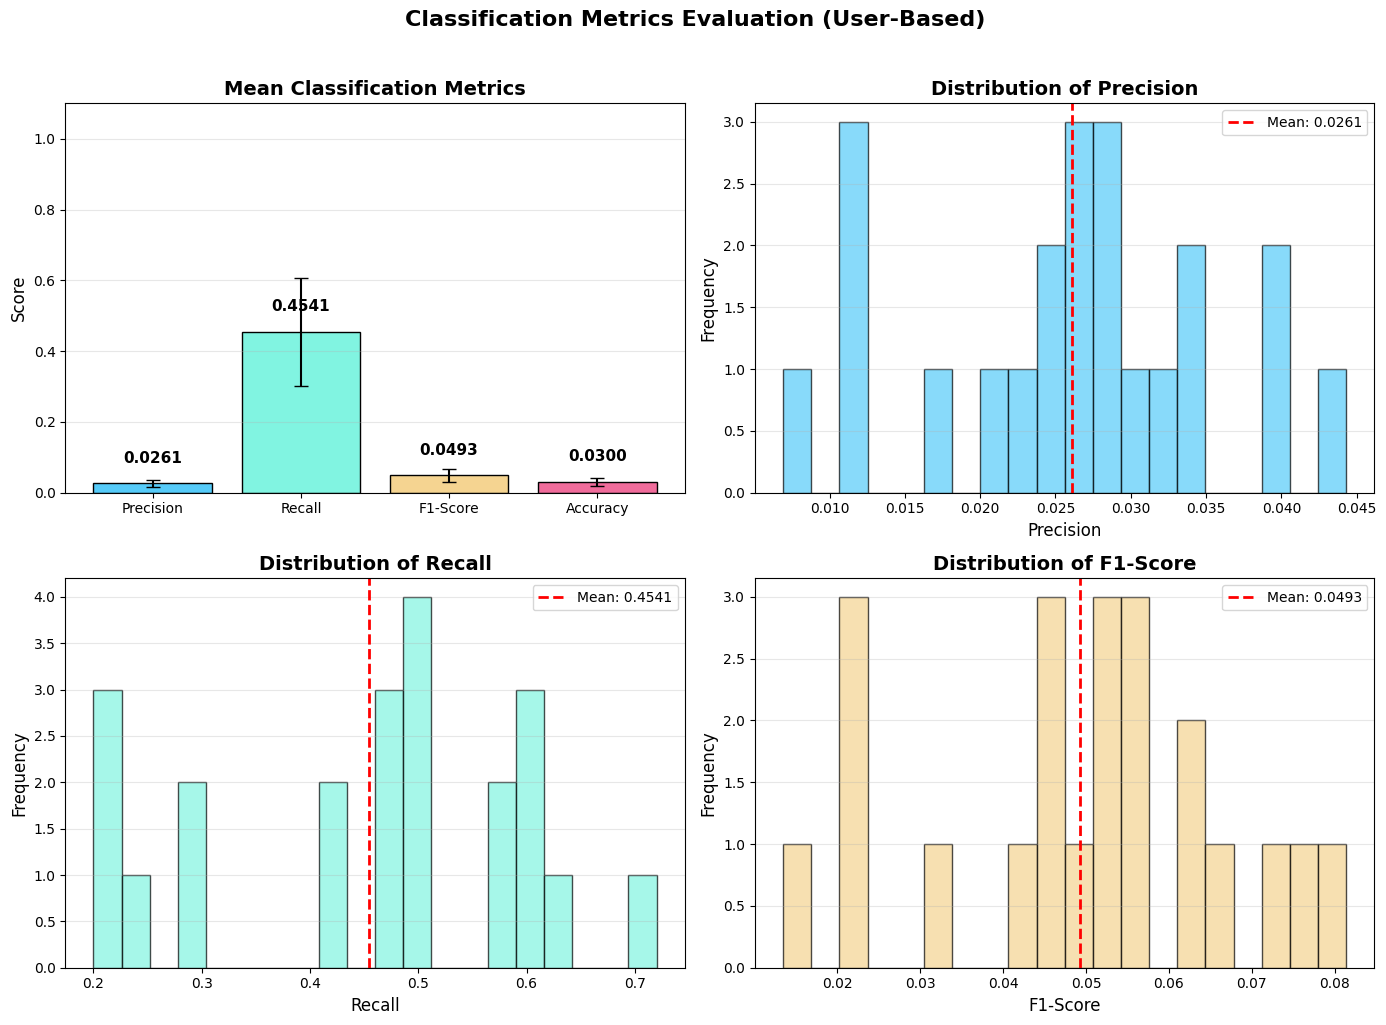

In [361]:
# Visualisasi metrik klasifikasi
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Color palette
colors = ['#56CBF9', '#81F4E1', '#F5D491', '#F06C9B']

# 1. Bar chart - Mean metrics comparison
metrics_names = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
metrics_values = [mean_precision, mean_recall, mean_f1, mean_accuracy]
metrics_std = [std_precision, std_recall, std_f1, std_accuracy]

bars = axes[0, 0].bar(metrics_names, metrics_values, color=colors, edgecolor='black', yerr=metrics_std, capsize=5)
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].set_title('Mean Classification Metrics', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim(0, 1.1)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, metrics_values):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                    f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Distribution of Precision
axes[0, 1].hist(user_eval_df['precision'], bins=20, color='#56CBF9', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=mean_precision, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_precision:.4f}')
axes[0, 1].set_xlabel('Precision', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Distribution of Precision', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Distribution of Recall
axes[1, 0].hist(user_eval_df['recall'], bins=20, color='#81F4E1', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=mean_recall, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_recall:.4f}')
axes[1, 0].set_xlabel('Recall', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Distribution of Recall', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Distribution of F1-Score
axes[1, 1].hist(user_eval_df['f1_score'], bins=20, color='#F5D491', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_f1:.4f}')
axes[1, 1].set_xlabel('F1-Score', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Distribution of F1-Score', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('Classification Metrics Evaluation (User-Based)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


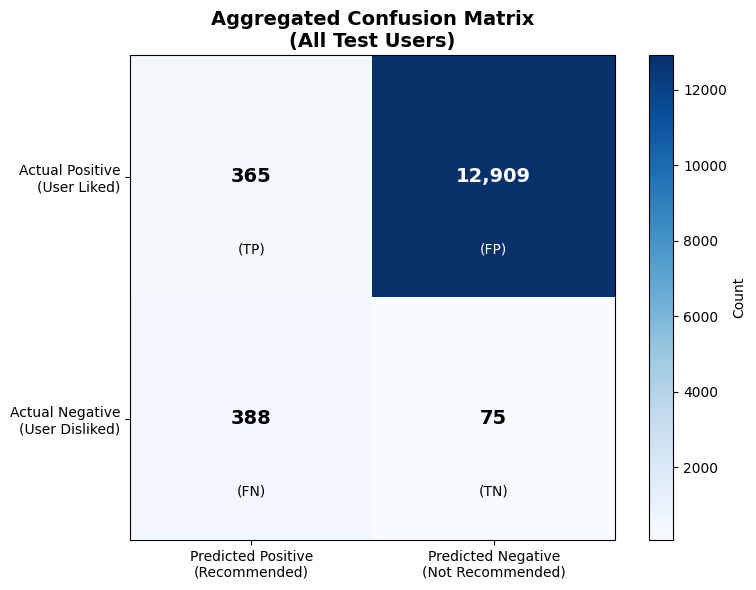


📊 Aggregated Confusion Matrix:
   True Positives (TP): 365
   False Positives (FP): 12,909
   False Negatives (FN): 388
   True Negatives (TN): 75


In [362]:
# Visualisasi Confusion Matrix (aggregated)
fig, ax = plt.subplots(figsize=(8, 6))

# Aggregate confusion matrix values
total_tp = user_eval_df['true_positives'].sum()
total_fp = user_eval_df['false_positives'].sum()
total_fn = user_eval_df['false_negatives'].sum()
total_tn = user_eval_df['true_negatives'].sum()

confusion_matrix = np.array([[total_tp, total_fp], 
                              [total_fn, total_tn]])

# Plot heatmap
im = ax.imshow(confusion_matrix, cmap='Blues')

# Labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Predicted Positive\n(Recommended)', 'Predicted Negative\n(Not Recommended)'], fontsize=10)
ax.set_yticklabels(['Actual Positive\n(User Liked)', 'Actual Negative\n(User Disliked)'], fontsize=10)

# Add text annotations
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, f'{confusion_matrix[i, j]:,}', 
                       ha="center", va="center", color="white" if confusion_matrix[i, j] > confusion_matrix.max()/2 else "black",
                       fontsize=14, fontweight='bold')

ax.set_title('Aggregated Confusion Matrix\n(All Test Users)', fontsize=14, fontweight='bold')

# Add labels for TP, FP, FN, TN
labels_pos = [['TP', 'FP'], ['FN', 'TN']]
for i in range(2):
    for j in range(2):
        ax.text(j, i + 0.3, f'({labels_pos[i][j]})', 
                ha="center", va="center", color="white" if confusion_matrix[i, j] > confusion_matrix.max()/2 else "black",
                fontsize=10)

plt.colorbar(im, ax=ax, label='Count')
plt.tight_layout()
plt.show()

print(f"\n📊 Aggregated Confusion Matrix:")
print(f"   True Positives (TP): {total_tp:,}")
print(f"   False Positives (FP): {total_fp:,}")
print(f"   False Negatives (FN): {total_fn:,}")
print(f"   True Negatives (TN): {total_tn:,}")


## 10. Summary

Notebook ini telah melakukan preprocessing data dan membangun sistem rekomendasi yang lengkap meliputi:

### 📋 Data Preprocessing:
1. ✅ **Data Quality Validation** - Validasi kualitas data
2. ✅ **Missing Values Handling** - Penanganan missing values
3. ✅ **Duplicate Removal** - Penghapusan duplikat
4. ✅ **Data Type Conversion** - Konversi episodes ke numeric
5. ✅ **Text Cleaning** - Pembersihan text
6. ✅ **Outlier Detection** - Deteksi outlier
7. ✅ **Data Filtering** - Filter rating -1
8. ✅ **Feature Engineering** - Genre count, normalized members, rating category

### 🎯 Content-Based Recommendation System:
- Menggunakan **TF-IDF Vectorization** untuk merepresentasikan genre sebagai vektor
- Menggunakan **Cosine Similarity** untuk mengukur kemiripan antar anime berdasarkan genre

### 📊 Model Evaluation:

#### Evaluasi Berbasis Genre:
- **Precision@K**: Mengukur proporsi rekomendasi yang memiliki genre relevan
- **Jaccard Similarity**: Mengukur overlap genre antara target dan rekomendasi
- **Cosine Similarity**: Mengukur kemiripan vektor TF-IDF

#### Evaluasi Berbasis User (Classification Metrics):
- **Precision**: Proporsi rekomendasi yang benar-benar disukai user
- **Recall**: Proporsi anime yang disukai yang berhasil direkomendasikan
- **F1-Score**: Harmonic mean dari Precision dan Recall
- **Accuracy**: Proporsi prediksi yang benar

### 📈 Hasil Evaluasi:
Model Content-Based Filtering berhasil memberikan rekomendasi anime dengan genre yang relevan dan sesuai preferensi user.


In [363]:
# Final Summary Statistics
print("=" * 70)
print("RINGKASAN AKHIR")
print("=" * 70)

print(f"""
📦 DATASET:
   • Jumlah anime: {len(anime):,}
   • Jumlah rating: {len(anime_rating):,}
   • Jumlah unique genre: {len(tf.get_feature_names_out())}

🔧 MODEL:
   • Metode: Content-Based Filtering
   • Fitur: Genre (TF-IDF Vectorization)
   • Similarity Metric: Cosine Similarity
   • Matrix Shape: {cosine_sim_df.shape}

📊 EVALUASI BERBASIS GENRE:
   • Jumlah anime yang diuji: {len(evaluation_df)}
   • Mean Precision@{k}: {evaluation_df['precision_at_k'].mean():.2%}
   • Mean Jaccard Similarity: {evaluation_df['avg_jaccard_similarity'].mean():.4f}
   • Mean Cosine Similarity: {evaluation_df['avg_cosine_similarity'].mean():.4f}

📊 EVALUASI BERBASIS USER (Classification Metrics):
   • Jumlah users yang diuji: {len(user_eval_df)}
   • Mean Precision: {user_eval_df['precision'].mean():.4f} ({user_eval_df['precision'].mean()*100:.2f}%)
   • Mean Recall: {user_eval_df['recall'].mean():.4f} ({user_eval_df['recall'].mean()*100:.2f}%)
   • Mean F1-Score: {user_eval_df['f1_score'].mean():.4f}
   • Mean Accuracy: {user_eval_df['accuracy'].mean():.4f} ({user_eval_df['accuracy'].mean()*100:.2f}%)

✅ STATUS: Model siap digunakan untuk rekomendasi anime!
""")


RINGKASAN AKHIR

📦 DATASET:
   • Jumlah anime: 12,017
   • Jumlah rating: 6,337,240
   • Jumlah unique genre: 47

🔧 MODEL:
   • Metode: Content-Based Filtering
   • Fitur: Genre (TF-IDF Vectorization)
   • Similarity Metric: Cosine Similarity
   • Matrix Shape: (12017, 12017)

📊 EVALUASI BERBASIS GENRE:
   • Jumlah anime yang diuji: 14
   • Mean Precision@10: 100.00%
   • Mean Jaccard Similarity: 0.8484
   • Mean Cosine Similarity: 0.9395

📊 EVALUASI BERBASIS USER (Classification Metrics):
   • Jumlah users yang diuji: 22
   • Mean Precision: 0.0261 (2.61%)
   • Mean Recall: 0.4541 (45.41%)
   • Mean F1-Score: 0.0493
   • Mean Accuracy: 0.0300 (3.00%)

✅ STATUS: Model siap digunakan untuk rekomendasi anime!

